## **Introduction**

##### In this notebook, we delves into the theoretical foundations and the mathematical intuition of time series models with real-world applications on **Singapore’s 1975 Q1 to 2024 Q4 Quarterly Gross Domestic Product (GDP) and Consumption data**. 

Link for Dataset: https://tablebuilder.singstat.gov.sg/

##### The analysis is divided into two main sections:

##### **Section 1: Time Series Forecasting on Singapore's GDP**: A forecasting model that captures the underlying trend, seasonality, and structure of the GDP series and generate reliable forecasts. We will walk through the entire process from time series assumptions, identifying stationarity, differencing and interpreting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to determine the suitable parameters of the SARIMA Model. 

##### **Section 2: Error Correction Model**: Investigate the long-run equilibrium relationship between GDP and Consumption, and how short-term deviations are adjusted over time. We will walk through the mathematical motivation behind Error Correction Model, cointegration and intepretation of the results in Economic term.

In [1]:
import os

file_directory = 'C:/Users/andyl/OneDrive/Documents/Projects/Time_Series' # change the file_directory accordingly

os.chdir(file_directory)

os.getcwd()

'C:\\Users\\andyl\\OneDrive\\Documents\\Projects\\Time_Series'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

In [3]:
df = pd.read_csv("Singapore_GDP_and_Consumption.csv")

In [4]:
df

,Data Series,GDP At Current Market Prices (Million Dollars),GDP At Current Market Prices -> Private Consumption Expenditure (Million Dollars)
0,1975 1Q,3209.4,1927.0
1,1975 2Q,3307.0,1983.1
2,1975 3Q,3519.3,2105.3
3,1975 4Q,3693.0,2232.8
4,1976 1Q,3545.1,2112.9
...,...,...,...
195,2023 4Q,175605.3,56390.1
196,2024 1Q,177584.0,56561.6
197,2024 2Q,183758.4,57221.2
198,2024 3Q,182225.6,57419.3


In [5]:
df.rename(columns = {"Data Series": "Quarter", "GDP At Current Market Prices (Million Dollars)": "GDP", "GDP At Current Market Prices -> Private Consumption Expenditure (Million Dollars)" : "Consumption"}, inplace = True)
df

,Quarter,GDP,Consumption
0,1975 1Q,3209.4,1927.0
1,1975 2Q,3307.0,1983.1
2,1975 3Q,3519.3,2105.3
3,1975 4Q,3693.0,2232.8
4,1976 1Q,3545.1,2112.9
...,...,...,...
195,2023 4Q,175605.3,56390.1
196,2024 1Q,177584.0,56561.6
197,2024 2Q,183758.4,57221.2
198,2024 3Q,182225.6,57419.3


## **1. Time Series Forecasting on Singapore's GDP**

### **1.1 Time Series Assumptions**

Before we do the forecasting, we have to state our assumption for time series regression. Let $\mathbf{x}_{t} = (x_{t1}, x_{t2}, ... , x_{tk})$

#### **Assumption TS 1: Linearity and Weakly Dependent**

- Linear in parameters

- In time series analysis, the assumption that observations are independent and identically distributed (i.i.d.) is often unrealistic. Instead, we assume that the stochastic process $\{(\mathbf{x}_{t}, y_{t}) : t = 1,2, \cdots, T\}$ are **stationary and weakly dependent**. Under these conditions, and the sufficiently large sample, we can apply the **Law of Large Number** and **Central Limit Theorem**.

- **Definition of Stationary and Weakly Dependent**:

    1. **Stationary** : For a time series to be stationary if for every subsequence collection of time indices $ 1 \leq t_{1} < t_{2} < \cdots < t_{m}$, the joint distribution for $(x_{t_{1}}, x_{t_{2}}, \cdots , x_{t_{m}})$ is the same of $(x_{t_{1} + h}, x_{t_{2} + h}, \cdots , x_{t_{m} +h}), \forall h \in \mathbb{Z}^{+}$. This assumption replaces the condition of identical distribution. We will adopt the weaker form of stationarity, **covariance stationarity**. 

        A stochastic process $\{x_{t} : t = 1,2,...,T\}$ is **covariance stationary** if:

        - $\mathbb{E}(x_{t})$ is constant and finite.

        - $Var(x_{t})$ is constant and finite.

        - $Cov(x_{t}, x_{t+h})$ depends only on the distance in time $h$, not location in time $t$

    2. **Weakly Dependent** : Instead of assuming independence in time series, we will limit to dependence in time series.

        - $corr(x_{t}, x_{t+h}) \rightarrow 0 \text{ as } h \rightarrow \infty$. This means as $x_{t+h}$ and $x_{t}$ get further apart in time, their correlation gets smaller, and becomes negligible asymptotically.

    3. **Example of Stationary and Weakly Dependent Time Series**:

        - Consider the following process $\{y_{t}\}$, which has the following equation: 
        
        $$ y_{t} = \phi y_{t-1} + e_{t}$$

        - where $\{ e_{t} : t = 1,2, \cdots,T\}$ is an i.i.d. sequence of error terms with $\mathbb{E}(e_{t}) = 0$ and $Var(e_{t}) = \sigma^2$. $\{e_{t}\}$ is also independent of $y_{t}$. This equation is an Auto-Regressive $\text{AR(1)}$ process. Notice that we can recursively expand the equation as such:

        $$y_{t} = \phi y_{t-1} + e_{t} \implies y_{t} = \phi (\phi y_{t-2} + e_{t-1}) + e_{t} = \phi^2 y_{t-2} + \phi e_{t-1} + e_{t}$$

        $$ \implies \cdots \implies y_{t} = \phi^{t} y_{0} + \phi^{t-1} e_{1} + \cdots + \phi e_{t-1} + e_{t} = \phi^{t} y_{0} + \sum_{j = 1}^{t}{\phi^{t-j}} e_{j}$$ 

        - Note that the expansion in the final line is a Moving Average ($\text{MA}$) process. In fact $\text{AR(1)}$ process is also a $\text{MA}(\infty)$ process. We will revisit the concept of $\text{AR}$ and $\text{MA}$ process later.

        - To prove $\{y_{t}\}$ is **covariance stationary**, assuming $\{e_{t}\}$ is independent to $y_{0}$, $\mathbb{E}(y_{0}) = c$, $Var(y_{0})$ exists and $|\phi| < 1 $ (stability condition), then:

            - $$ \mathbb{E}(y_{t}) = \phi^{t} \mathbb{E}(y_{0}) + \phi^{t-1} \mathbb{E}(e_{1}) + \cdots + \phi \mathbb{E}(e_{t-1}) + \mathbb{E}(e_{t})= c $$

            - $$ Var(y_{t}) = \phi^{2(t)} Var(y_{0}) + \phi^{2(t-1)} Var(e_{1}) + \cdots + \phi^2 Var(e_{t-1}) + Var(e_{t})$$
            
            $$ = \phi^{2t} Var(y_{0}) + [\phi^{2(t-1)} + \phi^{2(t-2)} + \cdots + \phi^2 + 1] \sigma^2 = \phi^{2t} Var(y_{0}) + \left[ \dfrac{1 - \phi^{2t}}{1 - \phi^2} \right] \sigma^2 $$

            - $$ Cov(y_{t}, y_{t+h}) = Cov \left(y_{t}, \phi^{t} y_{t} + \sum_{j = 1}^{h}{\phi^{t+h-j}} e_{j} \right) = \phi^{h} Var(y_{t})$$

            - Therefore, $\{y_{t}\}$ is covariance stationary. By covariance stationarity, we have $\mathbb{E}(y_{t}) = \mathbb{E}(y_{t-1})$ and $Var(y_{t}) = Var(y_{t-1})$. Hence we can have the following equations as such:

            $$ \mathbb{E}(y_{t}) = \phi \mathbb{E}(y_{t-1}) + E(e_{t}) \implies \mathbb{E}(y_{t}) = \phi \mathbb{E}(y_{t}) \implies \mathbb{E}(y_{t}) = 0 \text{, since } \phi \neq 1 $$

            $$ Var(y_{t}) = \phi^2 Var(y_{t-1}) + Var(e_{t}) \implies Var(y_{t}) = \phi^2 Var(y_{t}) + \sigma^2 \implies Var(y_{t}) = \dfrac{\sigma^2}{1-\phi^2} $$

        - To prove $\{y_{t}\}$ is **weakly dependent**,

            $$ corr(y_{t}, y_{t+h}) = \dfrac{Cov(y_{t}, y_{t+h})}{\sqrt{Var(y_{t})}\sqrt{Var(y_{t+h})}} = \dfrac{Cov(y_{t}, y_{t+h})}{\sqrt{Var(y_{t})}\sqrt{Var(y_{t})}} = \dfrac{Cov(y_{t}, y_{t+h})}{Var(y_{t})} = \phi^{h}
            $$

            - Clearly in this example, as $h \rightarrow \infty$, $corr(y_{t}, y_{t+h}) \rightarrow 0$. Hence, $\{y_{t}\}$ is **weakly dependent**.

        - Therefore $\{y_{t}\}$ is **covariance stationary and weakly dependent**. 

        
#### **Assumption TS 2: No perfect collinearity**

- None of the regressor in $\mathbf{x}_{t}$ is a perfect linear combination of the others.

#### **Assumption TS 3: Contemporaneous Exogeneity**

- $\mathbb{E}(e_{t}|\mathbb{x}_{t}) = 0$: The error term $e_{t}$ has zero conditional mean given $\mathbb{x_{t}}$ (regressors at time $t$)

- It is a weaker assumption of **Strict Exogeneity**, which assume $\mathbb{E} (e_{t}|\mathbf{x}_{s}) = 0, \quad \forall s \in {1,2, ... , T}$: The error term $e_{t}$ has zero condition mean given $\mathbf{x}_{s}$ for all time period $s$. However, **Strict Exogeneity** assumption is extremely difficult to hold in practical situation. Therefore, we typically assume **Contemporaneous Exogeneity** instead.

#### **Assumption TS 4: Contemporaneous Homoskedasticity**

- $Var(e_{t}|\mathbf{x}_{t}) = \sigma^2$

- Similar to TS 3, we condition only on the regressors at time $t$

#### **Assumption TS 5: No serial correlation (No autocorrelation)**

- Formally, it is written as $\mathbb{E}(e_{t} e_{s} | \mathbf{x}_{t}, \mathbf{x}_{s}) = 0$

- Informally, we remove the conditioning on $\mathbf{x}_{t}, \mathbf{x}_{s}$ for simplicity and say that $Corr(e_{t},e_{s}) = 0 \quad \forall t \neq s$

#### Reference:

- Introductory Econometrics: A Modern Approach 5th Edition (by Jeffrey M. Woodridge) Section 11.2

### **1.2 Exploratory Data Analysis on GDP**

In [6]:
singapore_gdp = df[['Quarter', 'GDP']].copy()

In [7]:
# to get a brand new DataFrame that is totally independent of the original, avoid the SettingWithCopyWarning
singapore_gdp_train = singapore_gdp[:-20].copy()
singapore_gdp_test = singapore_gdp[-20:].copy()

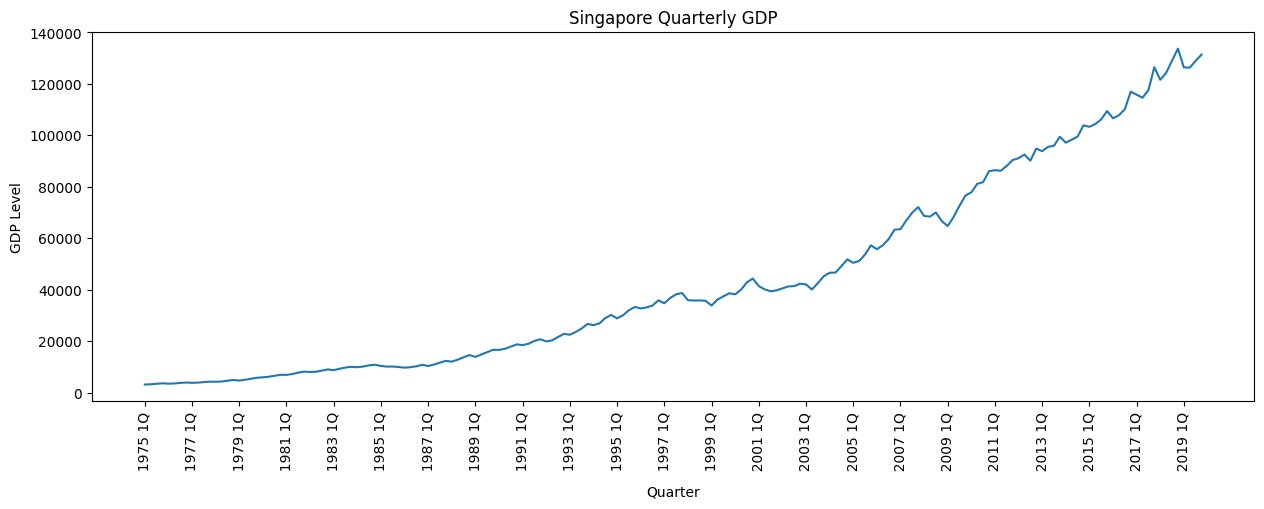

In [8]:
# Plot the GDP against time
plt.figure().set_figwidth(15)
plt.plot(singapore_gdp_train['Quarter'], singapore_gdp_train['GDP'])
plt.title("Singapore Quarterly GDP")

plt.xlabel("Quarter")
plt.xticks(singapore_gdp_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("GDP Level")
plt.show()

From GDP graph, we can observe that GDP exhibits an exponential time trend. To satisfy the TS 1 assumption (Linearity & Weakly Dependent), we will use the logarithmic function to transform exponential time trend to a linear trend. 

At time level $t$:

$$\log(\text{GDP}_{t}) = \beta_{0} + \beta_{1} t + v_{t} \text{ , } t = 1,2,\cdots ,T$$

Note that $\{v_{t}\}$ may not be **non-stationary** in this model as there is a upward trend in the $\log(\text{GDP})$ graph. We will explain further in Section 1.4, where we talk about **Unit Root Test**.

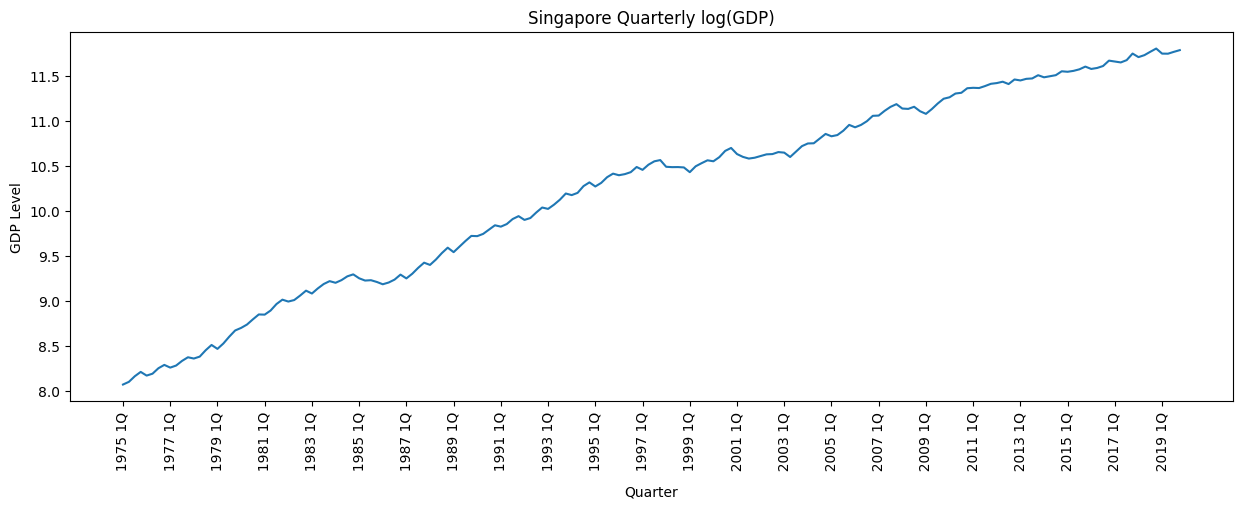

In [9]:
# Taking the logarithm to turn an exponential time trend to a linear time trend
singapore_gdp_train['log(GDP)'] = np.log(singapore_gdp_train['GDP'])

# Plotting the log(GDP) graph against time
plt.figure().set_figwidth(15)
plt.plot(singapore_gdp_train['Quarter'], singapore_gdp_train['log(GDP)'])
plt.title("Singapore Quarterly log(GDP)")

plt.xlabel("Quarter")
plt.xticks(singapore_gdp_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("GDP Level")
plt.show()

### **1.3 Highly Persistent and Trending Time Series**

Under TS 1 Assumption, we need our time series to be stationary and weakly dependent. Unfortunately, many economic time series exhibit strong dependence (persistence). It is often the case that highly persistent series also exhibit a clear trend. The $\log(\text{GDP})$ model clearly displays an upward trend. In fact, the behaviour of the $\log(\text{GDP})$ model can be classified as a **Random Walk process with drift**.

#### **1.3.1 Random Walk process & Random Walk with drift**

##### **Random Walk Process**

A **Random Walk process** is defined as:

$$ y_{t} = y_{t-1} + e_{t} $$

This is actually the $\text{AR(1)}$ process we have discussed earlier in Section 1.1 Time Series Assumptions, where $\phi = 1$ and $\{e_{t}\}$ is an i.i.d. sequence with $\mathbf{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$ (Note that $\{e_{t}\}$ can be **stationary and weakly dependent**). 

For a time series to be covariance stationary and weakly independent, we need $|\phi| < 1$. Since the requirement is clearly not satisfied, a random walk process is non-stationary (i.e. persistent).

##### **Random Walk Process with drift**

A **Random Walk process with drift** is defined as:

$$ y_{t} = \alpha_{0} + y_{t-1} + e_{t} $$

$\alpha_{0}$ is called the **drift term** and $\{e_{t}\}$ is an i.i.d. sequence with $\mathbf{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$ (Note that ${e_{t}}$ can be **stationary and weakly dependent**). To show that a **random walk process with drift** is trending, we recursively expand the equation:

$$ y_{t} = \alpha_{0} + y_{t-1} + e_{t} \implies y_{t} = \alpha_{0} + (\alpha_{0} + y_{t-2} + e_{t-1}) + e_{t} = 2\alpha_{0} + y_{t-2} + e_{t-1} + e_{t} $$

$$ \implies \cdots \implies y_{t} = \underbrace{t\alpha_{0}}_\text{trend} + \underbrace{e_{1} + e_{2} + \cdots e_{t-1} + e_{t}}_\text{random walk behaviour} $$

The $\log(\text{GDP})$ model exhibit a behaviour of a **Random Walk process with drift**. Hence, we can also model the $\log(\text{GDP})$ equation as:

$$ \log(\text{GDP}_{t}) = \alpha_{0} + \log(\text{GDP}_{t-1}) + e_{t} $$

#### **1.3.2 Unit Root Test**

To test if the time series is non-stationary, we test for the presence of a **unit root**. There are the **Dickey-Fuller Test** and the **Augmented Dickey-Fuller Test**.

##### **Dickey-Fuller Test**

We begin with the $\text{AR(1)}$ model. Consider:

$$ y_{t} = \phi y_{t-1} + e_{t} $$ 

where $\{e_{t}\}$ is an i.i.d. sequence with $\mathbf{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$, and $e_{t}$ is independent of $y_{t-1}, y_{t-2}, \cdots $.

We want to test:

$$ H_{0} : \phi = 1 \text{ (non-stationary, highly persistent)} $$
$$ H_{1} : \phi < 1 \text{ (stationary, weakly dependent)} $$

When testing for unit root, it is common to do the **differencing** (concepts will be discussed later) first to make the time series **stationary**. That is, to test for a unit root, we will use the test equation:

$$ y_{t} - y_{t-1} = \phi y_{t-1} + e_{t} - y_{t} $$

$$ \implies \Delta y_{t} = (\phi -1)y_{t-1} + e_{t} = \theta y_{t-1} + e_{t} \text{ where } \theta = \phi -1$$

Then the hypothesis will now be:

$$ H_{0} : \theta = 0 \text{ (non-stationary, highly persistent)} $$
$$ H_{1} : \theta < 0 \text{ (stationary, weakly dependent)} $$

The test statistic under $H_{0}$ is given by:

$$ \text{DF-test} = \dfrac{\hat{\theta}}{se(\hat{\theta})} $$

Due to the one-sided nature of our test $(H_{0}: \theta < 0)$, we will reject $H_{0}$ if the $\text{DF-test} \geq c_{\alpha}$, where $c_{\alpha}$ denotes the critical value given the significance level $\alpha$. (or $\text{p-value} < 0.05$) Depending on the process of interest,there are 3 test equations to conduct the **Dickey-Fuller Test**. 

1. **No Constant**: $\Delta y_{t} = \theta y_{t-1} + e_{t}$ 

2. **With Constant**: $ \Delta y_{t} = \alpha + \theta y_{t-1} + e_{t}$ 

3. **With Constant and Trend**: $ \Delta y_{t} = \alpha + \delta t + \theta y_{t-1} + e_{t} $

For example, our example $\log(\text{GDP})$ model:
$$ \log(\text{GDP}_{t}) = \beta_{0} + \beta_{1}t + v_{t} \quad , \quad v_{t} = \rho v_{t-1} + e_{t} $$

where $\{e_{t}\}$ is an i.i.d. sequence with $\mathbb{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$

Consider: 
$$ \log(\text{GDP}_{t}) - \rho \log(\text{GDP}_{t-1}) = (\beta_{0} + \beta_{1} t + v_{t}) - \rho \bigg[\beta_{0} + \beta_{1} (t-1) + e_{t-1}\bigg] $$

$$ \implies \log(\text{GDP}_{t}) - \rho \log(\text{GDP}_{t-1}) =  \bigg[(1-\rho) \beta_{0} + \rho \beta_{1}\bigg] + (1-\rho) \beta_{1} t + e_{t} - \rho e_{t-1} $$

$$ \implies \log(\text{GDP}_{t}) = \alpha + \delta t + \rho \log(\text{GDP}_{t-1}) + v_{t} \implies \Delta \log(\text{GDP}_{t}) = \alpha + \delta t + (1-\rho)\log(\text{GDP}_{t-1}) + v_{t}$$

$$ \implies \Delta \log(\text{GDP}_{t}) = \alpha + \delta t + \theta \log(\text{GDP}_{t-1}) + v_{t} $$

where $\alpha = (1-\rho) \beta_{0} + \rho \beta_{1}, \delta = (1-\rho) \beta_{1}, \theta = 1-\rho$. Hence we will use the test equation with Constant and Trend for the $\log(\text{GDP})$ model.

##### **Augmented Dickey-Fuller Test**

In **Dickey-Fuller Test**, we assume $\{e_{t}\}$ is an i.i.d. sequence, and hence the time series satisfy TS 5 Assumption (No Autocorrelation). 

In many finanical time series, however, have more complicated dynamic structures such as higher order $\text{AR}$ processes. In such cases, $\{e_{t}\}$ will often exhibits autocorrelation, violating TS 5 Assumption and leading to invalid standard errors for the test statistic. 

To address the autocorrelation issue, **Augmented Dickey-Fuller Test** includes lagged differences $\Delta y_{t-1} , \Delta y_{t-2}, \cdots $ to the test equation. The lagged differences helps to absorb the autocorrelation in the error terms. Otherwise, the test procedure and the core logic remain unchanged. 

In practice, we use the **Augmented Dickey-Fuller Test** to handle more general case, and we do so for our example.

##### Reference

- Introductory Econometrics: A Modern Approach 5th Edition (by Jeffrey M. Woodridge) Section 11.3 & 18.2

In [10]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(singapore_gdp_train['log(GDP)'])
print("ADF-statistic of log(GDP): ", results[0])
print("p-value: ", results[1])

ADF-statistic of log(GDP):  -2.3526193089380962
p-value:  0.15555802161680565


Since $\text{p-value} > 0.05$, we do not reject $H_{0}$ and we have a strong statistical evidence to claim that the $\log(\text{GDP})$ model is **not stationary**. Which is relatively obvious as it is trending upwards and hence $\mathbb{E}(\log(\text{GDP}_{t}))$ is **not constant**, and the series is **not stationary**.

### **1.4 Differencing and Order of Integration**

To deal with highly persistent time series, we can compute the different between consecutive observations, known as **Differencing**.

#### **1.4.1 Differencing**

Consider:

$$ y_{t} = y_{t-1} + e_{t} $$

where $\{e_{t}\}$ is **covariance stationary and weakly dependent** process.

We rearrange the equation and obtain:

$$ y_{t} - y_{t-1} = e_{t} \implies \Delta y_{t} = e_{t} $$

Since $\{e_{t}\}$ is a **covariance stationary and weakly dependent** process, $\{\Delta y_{t}\}$ is also a **covariance stationary and weakly dependent** process. Therefore, we can perform time series analysis on $\{\Delta y_{t}\}$ instead of $\{y_{t}\}$, whch is **non-stationary**.
 
#### **1.4.2 Order of Integration**

We say that a time series to be **integrated of order zero**, denoted as $I(0)$, if it is **stationary** and does not require **differencing**. $\{\Delta y_{t}\}$ derive above is an example. Therefore, we can write:

$$ \Delta y_{t} \sim I(0) $$

Using the same example, we can say that $\{y_{t}\}$ is **integrated of order one**, $I(1)$ because it can made **weakly dependent (and often stationary)** by **differencing** once. Therefore we can write:

$$ y_{t} \sim I(1) $$

Essentially, if $y_{t} \sim I(k)$, we say that there are $k$ number of **unit roots**, and we have perform **differencing** $k$ times on $y_{t}$ to remove the unit roots (i.e stationary).

In our example, the equation we are working:

$$ \log(\text{GDP}_{t}) = \alpha_{0} + \log(\text{GDP}_{t-1}) + e_{t} \implies \Delta \log(\text{GDP}_{t}) = \alpha_{0} + e_{t}$$

Note that $\alpha_{0}$ is a constant and won't affect the **stationarity** of the time series $\{\Delta \log(\text{GDP}_{t})\}$. We will make use of this notation in Section 2 **Error Correction Model**.

#### Reference:

- Introductory Econometrics: A Modern Approach 5th Edition (by Jeffrey M. Woodridge) Section 11.3

In [11]:
singapore_gdp_train['log(GDP) Lag 1'] = singapore_gdp_train['log(GDP)'].shift(1)
singapore_gdp_train['log(GDP) 1st Difference'] = singapore_gdp_train['log(GDP)'].diff(1)

In [12]:
singapore_gdp_train

,Quarter,GDP,log(GDP),log(GDP) Lag 1,log(GDP) 1st Difference
0,1975 1Q,3209.4,8.073839,NaN,NaN
1,1975 2Q,3307.0,8.103797,8.073839,0.029957
2,1975 3Q,3519.3,8.166017,8.103797,0.062221
3,1975 4Q,3693.0,8.214194,8.166017,0.048177
4,1976 1Q,3545.1,8.173322,8.214194,-0.040873
...,...,...,...,...,...
175,2018 4Q,133747.6,11.803710,11.767823,0.035886
176,2019 1Q,126434.4,11.747479,11.803710,-0.056231
177,2019 2Q,126324.4,11.746608,11.747479,-0.000870
178,2019 3Q,128968.5,11.767323,11.746608,0.020715


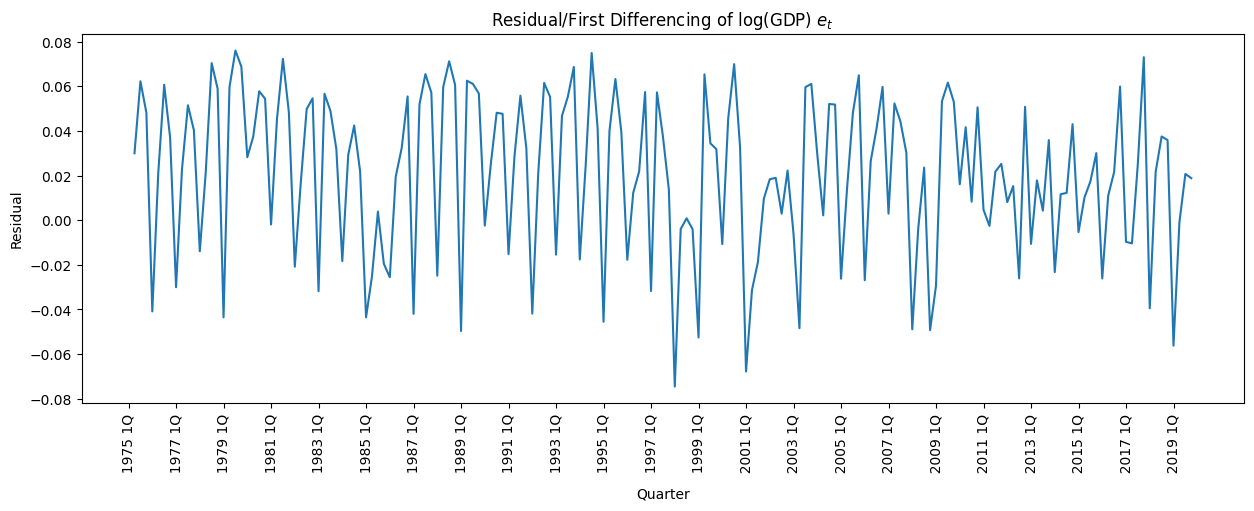

In [13]:
plt.figure().set_figwidth(15)
plt.plot(singapore_gdp_train['Quarter'], singapore_gdp_train['log(GDP) 1st Difference'])
plt.title("Residual/First Differencing of log(GDP) $e_{t}$")

plt.xlabel("Quarter")
plt.xticks(singapore_gdp_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("Residual")
plt.show()

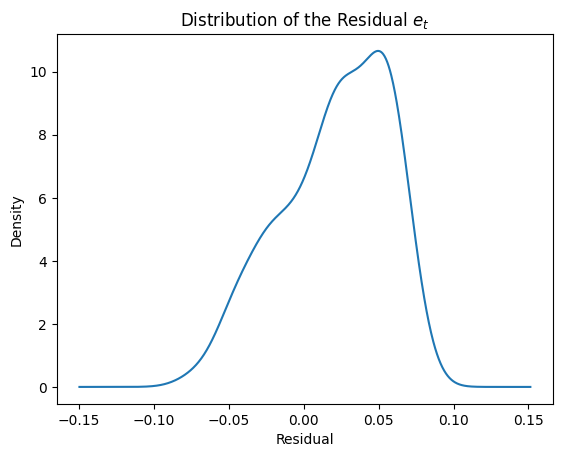

In [14]:
singapore_gdp_train['log(GDP) 1st Difference'].plot(kind = 'kde')

plt.title('Distribution of the Residual $e_{t}$')
plt.xlabel('Residual')
plt.show()

In [15]:
lag_1_results = adfuller(singapore_gdp_train['log(GDP) 1st Difference'].dropna())
print("ADF-statistic of log(GDP) Residual: ", lag_1_results[0])
print("p-value: ", lag_1_results[1])

ADF-statistic of log(GDP) Residual:  -2.749811779586032
p-value:  0.0658081044932974


At first glance, the residual series $\{e_{t}\}$, which also represent $\{\Delta \log(\text{GDP}_{t})\}$, appears to be random and is likely to be **stationary**. Furthermore, the distribution of the $e_{t}$ approximates a normal distribution with mean 0.

However, when we performed the **Augmented Dickey-Fuller Test** on the residual series $\{e_{t}\}$, $\text{p-value} > 0.05$, indicating insufficent evidence (at 5% level of significance) to claim that $\{e_{t}\}$ is **stationary**. 

There is a strong possibility of committing a Type II error since the $\text{p-value}$ is close to 0.05. However, further analysis reveals that the residual series $\{e_{t}\}$ exhibits **seasonality**, which is another form of **non-stationarity**. We will discuss this in more detail in the next section.

### **1.5 Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)**

Consider a **stationary** $\text{AR(1)}$ model:

$$y_{t} = \phi y_{t-1} + e_{t} $$ 

where $|\phi| < 1$ for stability condition and $\{e_{t}\}$ is an i.i.d sequence with $\mathbb{E}(e_{t}) = 0 , Var(e_{t}) = \sigma^2$

In Section 1.1 Time Series Assumption, we show that we can recursively expand $\text{AR(1)}$ model. By shifting the index by $h$, we obtain the following equation:

$$ y_{t+h} = \phi y_{t+h-1} + e_{t+h} \implies y_{t+h} = \phi (\phi y_{t+h-2} + e_{t+h-1}) + e_{t+h} = \phi^2 y_{t+h-2} + \phi e_{t+h-1} + e_{t+h} \implies $$
$$ \cdots \implies y_{t+h} = \phi^t y_{t} + \phi^{h-1} e_{t+1} + \phi^{h-2} e_{t+2} + \cdots + \phi e_{t+h-1} + e_{t+h} = \phi^t y_{t} + \sum_{j = 1}^{h}{\phi^{h-j} e_{t+j}} $$

Notice $y_{t+h}$ is dependent on $y_{t+h-1}$, $y_{t+h-1}$ is dependent on $y_{t+h-2}$, $\cdots$, $y_{t+1}$ is dependent on $y_{t}$. So through this chain of dependence, we see that $y_{t+h}$ is dependent to $y_{t}$

#### **1.5.1 Autocorrelation Function (ACF)**

**ACF** measures the **overall correlation** between a time series and its lagged values. Essentially, it is simply finding $corr(y_{t+h}, y_{t})$. 

**ACF** helpful to identify the order of the Moving Average ($\text{MA}$) process in the time series. We will revisit this in Section 1.6 where we determine the parameters for our forecasting model.

#### **1.5.2 Partial Autocorrelation Function (PACF)**

**PACF** measures the **partial correlation** between a time series and its lagged values, after removing the influence of the intermediate lags.

**PACF** helpful to identify the order of the Auto Regressive ($\text{AR}$) process in the time series. We will revisit this in Section 1.6 where we determine the parameters for our forecasting model.

From the stationary $\text{AR(1)}$ model earlier, we observe that $y_{t+h}$ is dependent to $y_{t+h-1}, y_{t+h-2}, \cdots, y_{t+1}$ through the chain of dependence. Likewise, we also observe that $y_{t+h-1}, y_{t+h-2}, \cdots, y_{t+1}$ are dependent to $y_{t}$. Therefore, we can imply that some of the correlation between $y_{t+h}$ and $y_{t}$ could be explained by the intermediate lags $y_{t+h-1},y_{t+h-2},\cdots y_{t+1}$. To remove the influence of the intermediate lags, we have to partial out the effect. 

##### **Method 1**

We let $\hat{y}_{t+h}$ and $\hat{y}_{t}$ be the regression of $y_{t+h}$ and $y_{t}$ on the intermediate lags $\{y_{t+1}, y_{t+2}, \cdots , y_{t+h-1}\}$ respectively. We can write the equation as:

$$ \hat{y}_{t+h} = \hat{\beta}_{1} y_{t+1} + \hat{\beta}_{2} y_{t+2} + \cdots \hat{\beta}_{h-1} y_{t+h-1} $$

$$ \hat{y}_{t} = \hat{\beta}_{1} y_{t+1} + \hat{\beta}_{2} y_{t+2} + \cdots \hat{\beta}_{h-1} y_{t+h-1} $$

Note no intercept in the regression, since $\mathbb{E}(y_{t}) = 0$ for stationary $\text{AR(1)}$ (Proven in Section 1.1). If it is not the case, we can simply replace $y_{t}$ with $y_{t} - \mu_{y}$. Also due to stationarity, the coefficient $\beta_{1},\cdots \beta_{h-1}$ are the same.

Then we find the **partial correlation** of a stationary process after removing the influence of the intermediate lags, denoted as $\phi_{h,h}$ for $h = 1,2, \cdots$:

$$ \phi_{1,1} = corr(y_{t+1},y_{t}) $$ 
$$\phi_{h,h} = corr\left(y_{t+h} - \hat{y}_{t+h}, y_{t} - \hat{y}_{t}\right), \text{ for } h \geq 2$$

Other expression of **partial correlation** could be written as:

$$ corr(y_{t+h}, y_{t}|y_{t+h-1}, \cdots, y_{t+1}) = \dfrac{Cov(y_{t+h}, y_{t}|y_{t+h-1},\cdots, y_{t+1})}{\sqrt{Var(y_{t+h}|y_{t+h-1},\cdots, y_{t+1})} \sqrt{Var(y_{t}|y_{t+h-1},\cdots, y_{t+1})}} $$

##### **Method 2**

Alternatively, to calculate the **partial correlation** of $y_{t+h}$ and $y_{t}$, we can also regress and obtain the following equation:

$$ \hat{y}_{t+h} = \hat{\beta}_{1} y_{t+1} + \hat{\beta}_{2} y_{t+2} + \cdots \hat{\beta}_{h-1} y_{t+h-1} + \hat{\beta}_{h} y_{t+h}$$

By **Frisch-Waugh-Lovell Theorem**, the $\hat{\beta}_{h}$ obtained from regressing the multiple regression model which include $y_{t+h}$ and all other intermediate lags $y_{t+1}, y_{t+2}, \cdots , y_{t+h-1}$ as controls is the same as the **partial correlation** obtained from Method 1.

#### Reference: 
- https://stats.stackexchange.com/questions/201919/utility-of-the-frisch-waugh-theorem
- https://mcs.utm.utoronto.ca/~nosedal/sta457/pacf.pdf
- https://online.stat.psu.edu/stat510/lesson/2/2.2
- Time Series Analysis and Its Application Third Edition by G.Casella, S.Fienberg, I.Olkin page 105 and 106

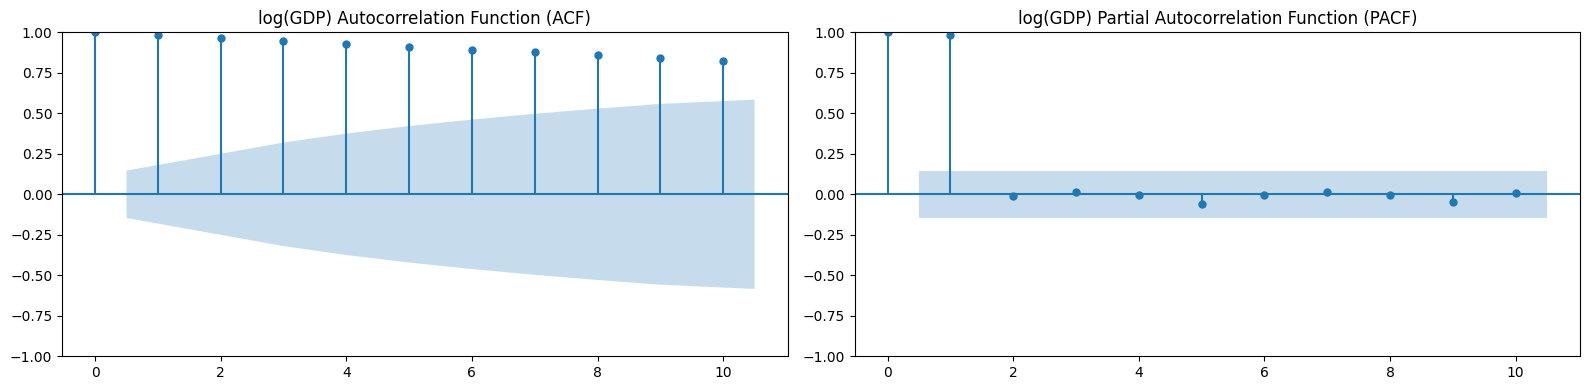

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, axes = plt.subplots(1,2, figsize = (16,4))

plot_acf(singapore_gdp_train['log(GDP)'], lags = 10, ax = axes[0])
axes[0].set_title("log(GDP) Autocorrelation Function (ACF)")

plot_pacf(singapore_gdp_train['log(GDP)'], lags = 10, ax = axes[1])
axes[1].set_title("log(GDP) Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

From the $\log(\text{GDP})$ ACF plot for lag 1 to 10, we notice that there are spikes in all the lags, i.e. $Cov(\log(\text{GDP}_{t+h}), \log(\text{GDP}_{t}))$ are all significant for $1 \leq h \leq 10$. However, the $\log(\text{GDP})$ PACF plot only show a spike in lag 1. This means perhaps the autocorrelation at lags 2 and above are merely due to propagation of the autocorrelation at lag 1.

This behaviour strongly suggests that the time series $\{\log(\text{GDP}_{t})\}$ is non-stationary, which is consistent with the result of **Augmented Dickey-Fuller Test** performed on the time series $\{\log(\text{GDP}_{t})\}$.

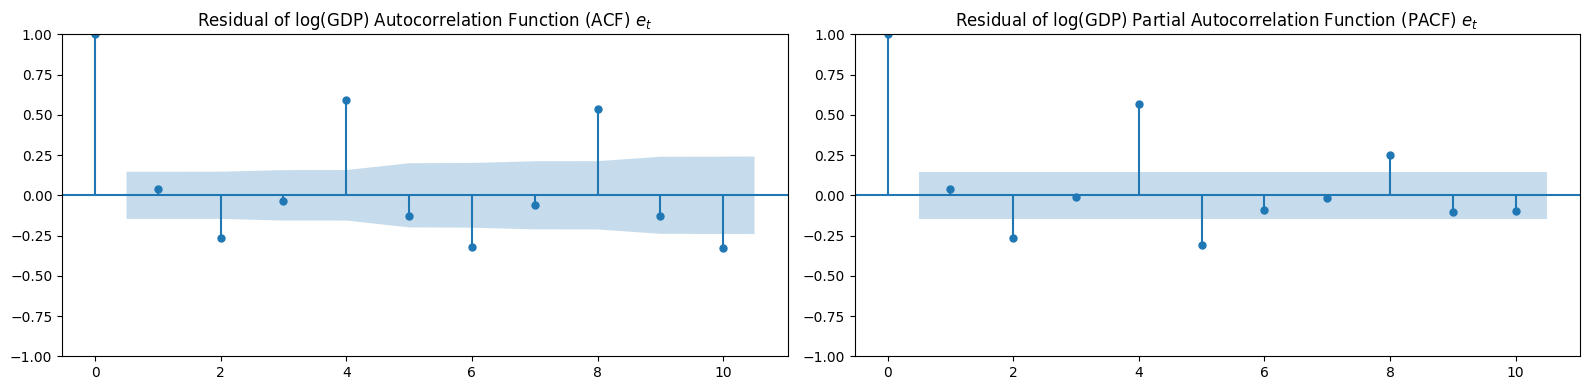

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, axes = plt.subplots(1,2, figsize = (16,4))

plot_acf(singapore_gdp_train['log(GDP) 1st Difference'].dropna(), lags = 10, ax = axes[0])
axes[0].set_title("Residual of log(GDP) Autocorrelation Function (ACF) $e_{t}$")

plot_pacf(singapore_gdp_train['log(GDP) 1st Difference'].dropna(), lags = 10, ax = axes[1])
axes[1].set_title("Residual of log(GDP) Partial Autocorrelation Function (PACF) $e_{t}$")

plt.tight_layout()
plt.show()

In the Residual of $\text{log(\text{GDP})}$ graph that was plotted earlier suggest that the residual series $\{e_{t}\}$, which also represent $\{\Delta \log(\text{GDP}_{t})\}$, is stationary and seems to be random. 

However, when we performed the **Augmented Dickey-Fuller Test** on the residual series $\{e_{t}\}$, the $\text{p-value} > 0.05$, indicating insufficent evidence (at 5% level of significance) to claim that $\{e_{t}\}$ is stationary.

Interestingly, the $e_{t}$ ACF and PACF plots of the exhibit spikes at every 4 lags, which likely reflects the quarterly structure of the data. Although the $\log(\text{GDP})$ time series shows a clear upward trend, the seasonal pattern is not easily observable by simply eyeballing the graph. This suggests that $\log(\text{GDP})$ contains a form of hidden **seasonality** that only becomes evident through statistical tools such as autocorrelation analysis.

Therefore, we not only need to apply first-order differencing (lag 1) to $\log(\text{GDP})$ to **detrend** the series, but also apply seasonal differencing (lag 4) to **deseasonalise** it. Note that the length of the seasonal lag can vary depending on the data's frequency and underlying patterns.

We proceed to deseasonalize the residual series, denoted as $\{\Delta_{4} e_{t}\}$.

In [18]:
# Deseasonalise the log(GDP) 1st Difference (or the Residual)

singapore_gdp_train['log(GDP) 1st Difference Lag 4'] = singapore_gdp_train['log(GDP) 1st Difference'].shift(4)
singapore_gdp_train['Residual Seasonal Difference'] = singapore_gdp_train['log(GDP) 1st Difference'].diff(4)

In [19]:
singapore_gdp_train

,Quarter,GDP,log(GDP),log(GDP) Lag 1,log(GDP) 1st Difference,log(GDP) 1st Difference Lag 4,Residual Seasonal Difference
0,1975 1Q,3209.4,8.073839,NaN,NaN,NaN,NaN
1,1975 2Q,3307.0,8.103797,8.073839,0.029957,NaN,NaN
2,1975 3Q,3519.3,8.166017,8.103797,0.062221,NaN,NaN
3,1975 4Q,3693.0,8.214194,8.166017,0.048177,NaN,NaN
4,1976 1Q,3545.1,8.173322,8.214194,-0.040873,NaN,NaN
...,...,...,...,...,...,...,...
175,2018 4Q,133747.6,11.803710,11.767823,0.035886,0.073012,-0.037126
176,2019 1Q,126434.4,11.747479,11.803710,-0.056231,-0.039457,-0.016774
177,2019 2Q,126324.4,11.746608,11.747479,-0.000870,0.021718,-0.022588
178,2019 3Q,128968.5,11.767323,11.746608,0.020715,0.037492,-0.016777


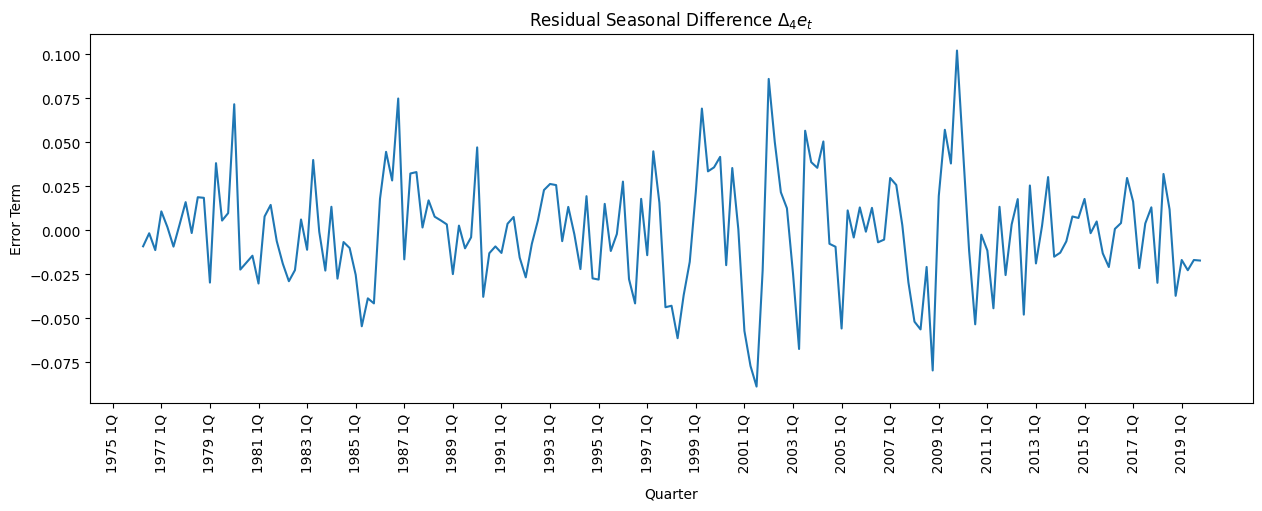

In [20]:
plt.figure().set_figwidth(15)
plt.plot(singapore_gdp_train['Quarter'], singapore_gdp_train['Residual Seasonal Difference'])
plt.title("Residual Seasonal Difference $\Delta_{4} e_{t}$")

plt.xlabel("Quarter")
plt.xticks(singapore_gdp_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("Error Term")
plt.show()

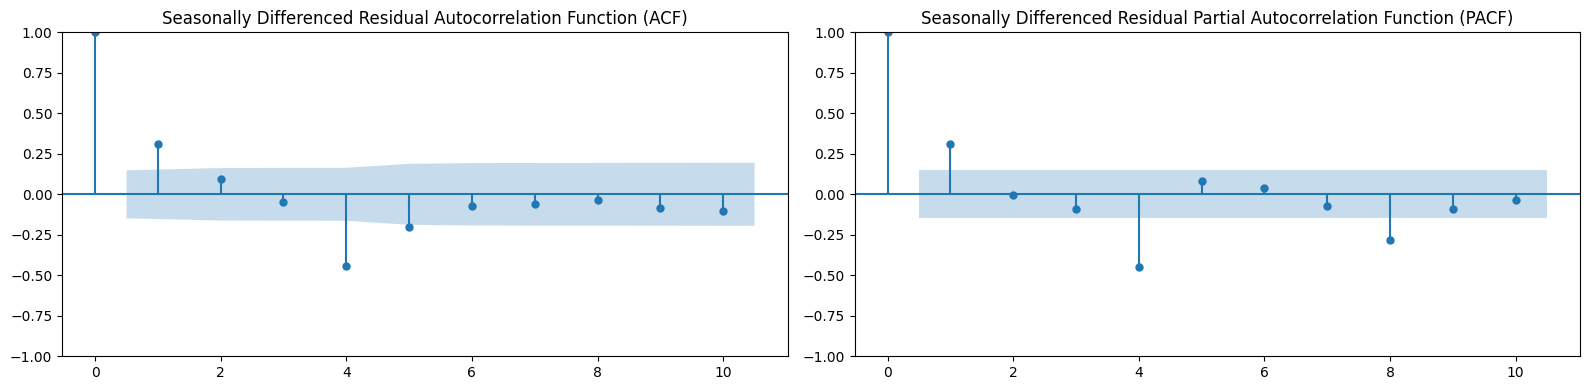

In [21]:
fig, axes = plt.subplots(1,2, figsize = (16,4))

plot_acf(singapore_gdp_train['Residual Seasonal Difference'].dropna(), lags = 10, ax = axes[0])
axes[0].set_title("Seasonally Differenced Residual Autocorrelation Function (ACF)")

plot_pacf(singapore_gdp_train['Residual Seasonal Difference'].dropna(), lags = 10, ax = axes[1])
axes[1].set_title("Seasonally Differenced Residual Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [22]:
seasonal_results = adfuller(singapore_gdp_train['Residual Seasonal Difference'].dropna())
print("ADF-statistic of Residual Seasonal Difference: ", seasonal_results[0])
print("p-value: ", seasonal_results[1])

ADF-statistic of Residual Seasonal Difference:  -7.086696478927506
p-value:  4.519131832952297e-10


In the ACF and PACF for our Seasonally Differenced residuals, we still observe some remaining significant spikes at lag 4. However, after applying both first-order and seasonal differencing of $\log(\text{GDP})$, the unit root test yields a p-value well below 0.05. 

This provides strong evidence against the presence of a unit root in the residual seasonal difference series $\{\Delta_{4} e_{t}\}$, confirming that the series has been successfully transformed to stationarity.

### **1.6 Seasonal Auto Regressive Integrated Moving Average ($\text{SARIMA}$)**

#### **1.6.1 Order of the Auto Regressive ($\text{AR}$) process**

To determine the **order of the $\text{AR}$ process**, we look at the **PACF** plot. Consider a stationary $\text{AR(p)}$ model:

$$y_{t+h} = \phi_{1} y_{t+h-1} + \phi_{2} y_{t+h-2} + \cdots \phi_{p} y_{t+h-p} + e_{t} = \sum_{j=1}^{p}{\phi_{j} y_{t+h-j}} + e_{t} $$

where $\{e_{t}\}$ is an i.i.d. sequence with $\mathbb{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$

##### **Behaviour of PACF for $\text{AR}$ process**

If $ h > p$ , then regressing $y_{t+h}$ on $\{y_{t+1}, y_{t+2}, \cdots y_{t+h-p-1}, y_{t+h-p}, \cdots y_{t+h-1} \}$ is just the model itself. From the structure of the $\text{AR(p)}$ equation, it doesn't have any terms $\{y_{t+1}, y_{t+2}, \cdots, y_{t+h-p-1} \}$, so the estimated coefficient for those terms are all zeroes. 

As we regress $y_{t+h}$ with the remaining regressors $\{y_{t+h-p}, \cdots, y_{t+h-1} \}$, it is simply the $\text{AR(p)}$ model itself. Therefore:

$$\hat{y}_{t+h} = \sum_{j=1}^{p}{\phi_{j} y_{t+h-j}}$$

Thus when $h > p$, 

$$ \phi_{h,h} = corr(y_{t+h} - \hat{y}_{t+h}, y_{t} - \hat{y}_{t}) = corr(e_{t+h}, y_{t} - \hat{y}_{t}) = 0 $$

Therefore, if the **PACF cuts off after lag $p$**, then we can reasonably infer that the time series $\{y_{t}\}$ has the **behaviour of $\text{AR(p)}$ process**. 

##### **Behaviour of ACF for $\text{AR}$ process**

As for **ACF**, the computation of correlation can become quite complex for a general $\text{AR(p)}$,  but key insights can be drawn from the simple, stationary $\text{AR(1)}$ case. As established in Section 1.1, for a stationary $\text{AR(1)}$ process:
$$ corr(y_{t}, y_{t+h}) = \phi^{h} $$

Note that since $|\phi| < 1$, **ACF** will show **decaying behaviour** if $\phi$ is positive, or **sinusoidal behaviour** if $\phi$ is negative. **This characteristic behaviour will extend to higher order $\text{AR(p)}$ model**. 

#### **1.6.2 Order of the Moving Average ($\text{MA}$) prcoess**

To determine the **order of the $\text{MA}$ process**, we look at the **ACF** plot. Consider a stationary $\text{MA(q)}$ model:

$$ y_{t+h} = e_{t+h} + \theta_{1} e_{t+h-1} + \theta_{2} e_{t+h-2} + \cdots \theta_{q} e_{t+h-q} = \sum_{j=0}^{q}{\theta_{j} e_{t+h-j}} \quad \text{where} \quad \theta_{0} = 1 $$

where $\{e_{t}\}$ is an i.i.d. sequence with $\mathbb{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$

##### **Behaviour of ACF for $\text{MA}$ process**

$$ Cov(y_{t}, y_{t+h}) = Cov \left(  \sum_{k=0}^{q}{\theta_{k} e_{t-k}}, \sum_{j=0}^{q}{\theta_{j} e_{t+h-j}} \right) $$

If $ 1 \leq h \leq q $, then by replacing the dummy index $j$ with $k+h$, we can rewrite the covariance as: 

$$ Cov(y_{t},y_{t+h}) = Cov \left( \sum_{k=0}^{q}{\theta_{k} e_{t-k}}, \sum_{k=h}^{q-h}{\theta_{k+h} e_{t-k}} \right) = \sum_{k=h}^{q-h}{\theta_{k} \theta_{k+h} Var(e_{t})} = \sigma^2 \sum_{k=h}^{q-h}{\theta_{k} \theta_{k+h}} $$

If $h > q$, then $y_{t}$ and $y_{t+h}$ will not have any common error terms, and hence:

$$ Cov(y_{t}, y_{t+h}) = 0 $$

Note that since $\{e_{t}\}$ is an i.i.d. sequence: 

$$ Var(y_{t+h}) = Var(e_{t+h}) + \theta_{1}^{2} Var(e_{t+h-1}) + \theta_{2}^{2} Var(e_{t+h-2}) + \cdots \theta_{q}^{2} Var(e_{t+h-q}) = (1 + \theta_{1}^{2} + \theta_{2}^{2} + \cdots + \theta_{q}^{2}) \sigma^2 $$ 

Since we assume $\text{MA(q)}$ model is stationary, then $\mathbb{E}(y_{t}) = \mathbb{E}(y_{t+h})$ and $Var(y_{t}) = Var(y_{t+h})$.

Therefore, the autocorrelation will be:

$$corr(y_{t}, y_{t+h}) = \dfrac{Cov(y_{t}, y_{t+h})}{\sqrt{Var(y_{t})}\sqrt{Var(y_{t+h})}} = \dfrac{Cov(y_{t}, y_{t+h})}{\sqrt{Var(y_{t})}\sqrt{Var(y_{t})}} = \dfrac{Cov(y_{t}, y_{t+h})}{Var(y_{t})} =
\begin{cases}
\dfrac{\sum_{k=h}^{q-h}{\theta_{k} \theta_{k+h}}}{1 + \theta_{1}^{2} + \theta_{2}^{2} + \cdots + \theta_{q}^{2}} & \quad 0 \leq h \leq q \\
0 & \quad h > q
\end{cases}
$$

Therefore, if the **ACF cuts off after lag $q$**, then we can reasonably infer that the time series $\{y_{t}\}$ is probably a **$\text{MA(q)}$ process**. 

##### **Behaviour of PACF for $\text{AR}$ process**

As for **PACF**, the computation of correlation can become quite complex for a general $\text{MA(q)}$, but we can intuitively infer from autocorrelation $corr(y_{t}, y_{t+h})$. 

For $1 \leq h \leq q$, each time when the lag $h$ increases by 1, we conditioning one additional intermediate lag in the set $\{y_{t+1}, y_{t+2}, \cdots y_{t+h-1} \}$. Therefore, as the set of intermediate lags expands, more of indirect dependence between $y_{t}$ and $y_{t+h}$ is partialled out, resulting a progressively weaker partial correlation as $h$ increases. 

As for $h > q$, since the correlation is already 0, then the partial correlation will also be 0.

Therefore, **PACF** will also have a **decaying behaviour** or **sinusoidal behaviour** if the series is a $\text{MA}$ process.

So the behaviour of the **ACF** and **PACF** can be summarise in a table:

|       | $\text{AR(p)}$ | $\text{MA(q)}$ | $\text{ARMA(p,q)}$ |
|-------|-------|-------|-----------|
|  ACF  | Decaying or Sinusoidal Behaviour | Cuts off after lag $q$ | Decaying or Sinusoidal Behaviour |
| PACF  | Cuts off after lag $p$ | Decaying or Sinusoidal Behaviour | Decaying or Sinusoidal Behaviour |

#### **Determining the parameters for $\text{SARIMA}$**

A $\text{SARIMA}$ model can be written as:

$$ \text{SARIMA} \underbrace{(p,d,q)}_\text{non-seasonal} \underbrace{(P,D,Q)_{m}}_\text{seasonal} $$

where:

- $p \rightarrow $  Order of $\text{AR}$ component in the **non-seasonal** part
- $d \rightarrow $  Degree of **non-seasonal differencing** (i.e order of integration)
- $q \rightarrow $  Order of $\text{MA}$ component in the **non-seasonal** part 
- $P \rightarrow $  Order of $\text{AR}$ component in the **seasonal** part 
- $D \rightarrow $  Degree of **seasonal differencing** 
- $Q \rightarrow $  Order of $\text{MA}$ component in the **seasonal** part
- $m \rightarrow $ number of periods per season

Note: The approach to identifying the seasonal parameters $P,D,Q$ is the same as for the non-seasonal parameters, but applied to **seasonal data**.

Supposed we want to express the equation of $\text{SARIMA}(1,1,1) (1,1,1)_{4}$, a compact and interpretable form is:

$$ (1 - \phi_{1}B)(1-\Phi_{1}B^4)(1-B)(1-B^4)y_{t} = (1 + \theta_{1}B)(1 + \Theta_{1}B^4)e_{t}$$

where: 
- $B$ is the **backshift operator**. For example, $By_{t} = y_{t-1}, B^{4}y_{t} = y_{t-4}$
- $\phi_{1}$ and $\theta_{1}$ are the **non-seasonal** $\text{AR}$ and $\text{MA}$ component respectively
- $\Phi_{1}$ and $\Theta_{4}$ are the **seasonal** $\text{AR}$ and $\text{MA}$ component respectively
- $(1-B)$ and $(1-B^4)$ represent the **non-seasonal** and **seasonal** differencing respectively

Expand the terms and we can get the explicit form of the SARIMA model.

#### Reference:
- https://otexts.com/fpp2/seasonal-arima.html
- Time Series Analysis and Its Application Third Edition by G.Casella, S.Fienberg, I.Olkin (Section 3.4 Autocorrelation and Partial Autocorrelation)

#### **1.6.3 The ACF and PACF of the Residual of $\log(\text{GDP})$ and the Seasonally Differenced Residual**

We now revisit the ACF and PACF of the residuals of $\log(\text{GDP})$ series and the seasonally differenced residuals.

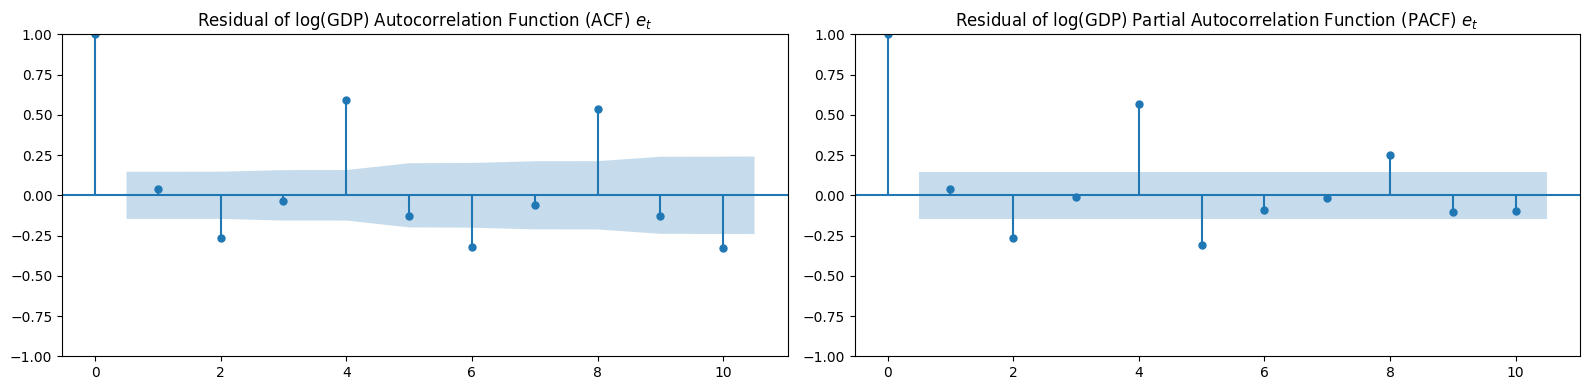

In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

fig, axes = plt.subplots(1,2, figsize = (16,4))

plot_acf(singapore_gdp_train['log(GDP) 1st Difference'].dropna(), lags = 10, ax = axes[0])
axes[0].set_title("Residual of log(GDP) Autocorrelation Function (ACF) $e_{t}$")

plot_pacf(singapore_gdp_train['log(GDP) 1st Difference'].dropna(), lags = 10, ax = axes[1])
axes[1].set_title("Residual of log(GDP) Partial Autocorrelation Function (PACF) $e_{t}$")

plt.tight_layout()
plt.show()

We observed **sinusoidal behaviour** from both ACF and PACF for **Residual** of $\log(\text{GDP})$. Based on this, we assume that it may be a $\text{ARMA}$ model. Therefore we will tentatively choose the parameters $p = 1, d = 1, q = 1$ first. $d = 1$ is because we applied **non-seasonal differencing**.

Recall that the **Augmented Dickey-Fuller Test** on the **Residual** returns $p-value = 0.0658 > 0.05$. This suggests that the series may still be non-stationary. Furthermore, the pattern ACF and PACF plot indicates the $\log(\text{GDP})$ may suffered **seasonality**, therefore we proceed to apply **seasonal differencing** to achieve stationarity.

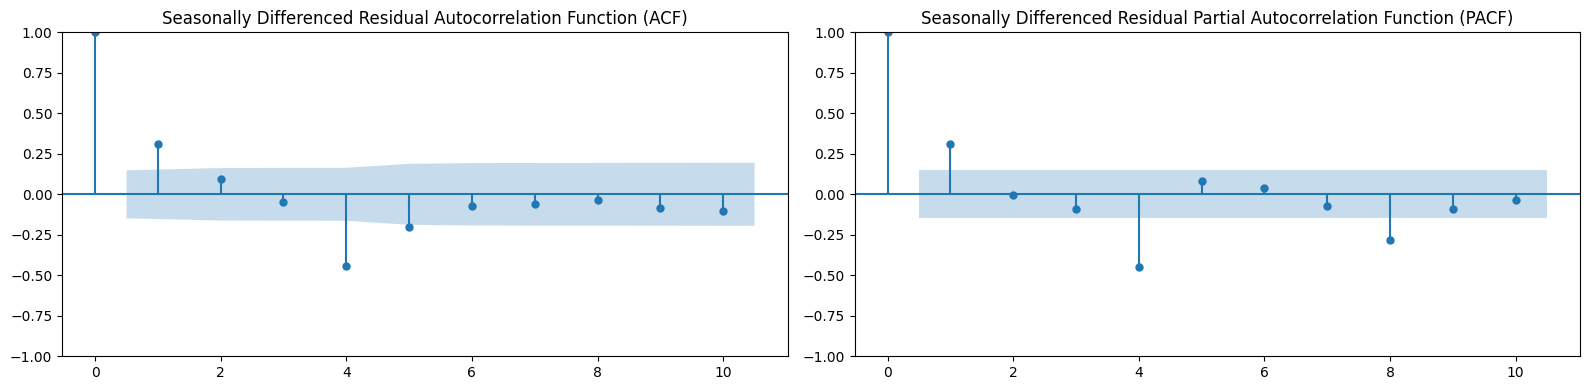

In [24]:
fig, axes = plt.subplots(1,2, figsize = (16,4))

plot_acf(singapore_gdp_train['Residual Seasonal Difference'].dropna(), lags = 10, ax = axes[0])
axes[0].set_title("Seasonally Differenced Residual Autocorrelation Function (ACF)")

plot_pacf(singapore_gdp_train['Residual Seasonal Difference'].dropna(), lags = 10, ax = axes[1])
axes[1].set_title("Seasonally Differenced Residual Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

Again, we observed **sinusoidal behaviour** from both ACF and PACF for **Seasonally Differenced Residual** of $\log(\text{GDP})$. Based on this, we assume that it may be a **seasonal** $\text{ARMA}$ model. Therefore we will tentatively choose the parameters $P = 1, D = 1, Q = 1, m = 4$. $D = 1$ is because we applied **non-seasonal differencing** and $m = 4$ since we observe significiant spikes in lag 4 from the ACF and PACF for **Residual** of $\log(\text{GDP})$.

We still observe some remaining significant spikes at lag 4. However, recall that the **Augmented Dickey-Fuller Test** on the **Seasonally Difference Residual** returns $\text{p-value} \ll 0.001$.This provides strong evidence against the presence of a unit root in the residual seasonal difference series $\{\Delta_{4} e_{t}\}$, confirming that the series has been successfully transformed to stationarity.

Overall we start with $\text{SARIMA}(1,1,1)(1,1,1)_{4}$ model.

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(singapore_gdp_train['log(GDP)'], order=(1, 1, 1), seasonal_order = (1,1,1,4))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          log(GDP)   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                 406.516
Date:                           Fri, 18 Apr 2025   AIC                           -803.033
Time:                                   16:13:13   BIC                           -787.209
Sample:                                        0   HQIC                          -796.614
                                           - 180                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4494      0.178      2.530      0.011       0.101       0.798
ma.L1         -0.1627      0.203     -0.800

From the $\text{SARIMA}(1,1,1)(1,1,1)_{4}$ model summary, the estimated coefficient of $\text{MA.L1}$ and $\text{AR.S.L4}$ are insignificant, therefore they are insignificant to our model, so we can consider removing them to simplify our model.

As a result, we are proceed to evaluate the simplified model $\text{SARIMA}(1,1,0)(0,1,1)_{4}$.

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima_model = SARIMAX(singapore_gdp_train['log(GDP)'], order=(1, 1, 0), seasonal_order = (0,1,1,4))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            log(GDP)   No. Observations:                  180
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 404.879
Date:                             Fri, 18 Apr 2025   AIC                           -803.758
Time:                                     16:13:14   BIC                           -794.264
Sample:                                          0   HQIC                          -799.907
                                             - 180                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2961      0.060      4.944      0.000       0.179       0.414
ma.S.L4       -0.8748      

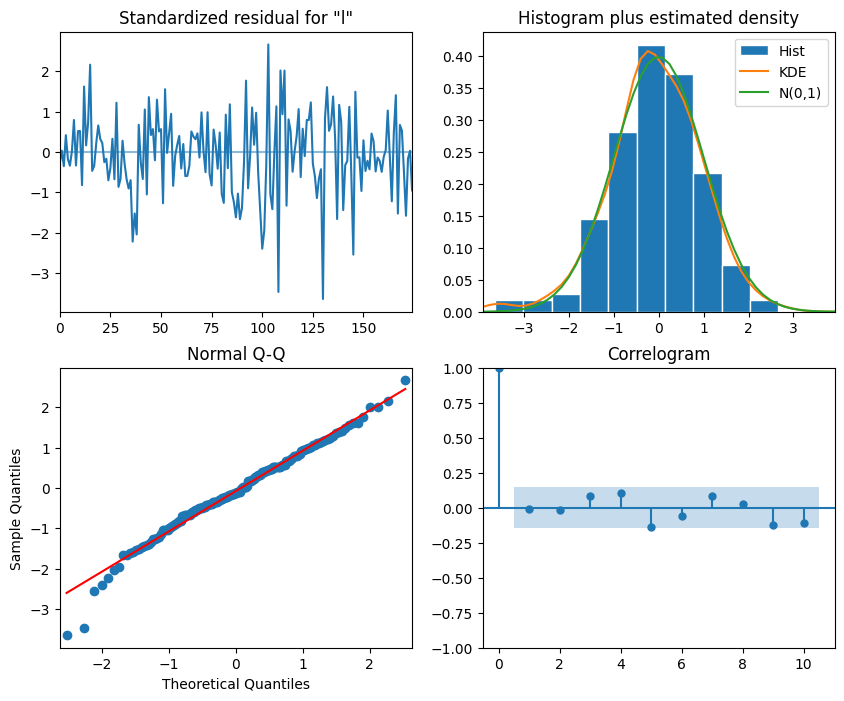

In [27]:
fig = arima_model_fit.plot_diagnostics(figsize = (10,8))
plt.show()

From the $\text{SARIMA}(1,1,0)(0,1,1)_{4}$ model summary, all the estimated coefficient are significant, indicating that the regressors contribute meaningfully to the model.

Furthermore, from the Plot Diagnostic, we can observe that $\text{SARIMA}(1,1,0)(0,1,1)_{4}$ is a relatively good forecasting model:

- **Standardised Residual**: model residuals look very random and centred around 0, behaving like a white noise

- **Histogram plus estimated density**: model residuals forms a Normal distribution approximately

- **Normal Q-Q**: Compares the quantiles of your residuals against the theoretical quantiles from a standard normal distribution, and majority of the point lies on the 45-degree line, indicating the model residuals are approximately normal.

- **Correlogram**: ACF of the model residuals has no significant spikes, suggesting that the model have effectively captured the underlying time series structure.

### **1.7 Out-of-Sample Forecasting**

In [28]:
singapore_gdp_test["log(GDP)"] = np.log(singapore_gdp_test["GDP"])

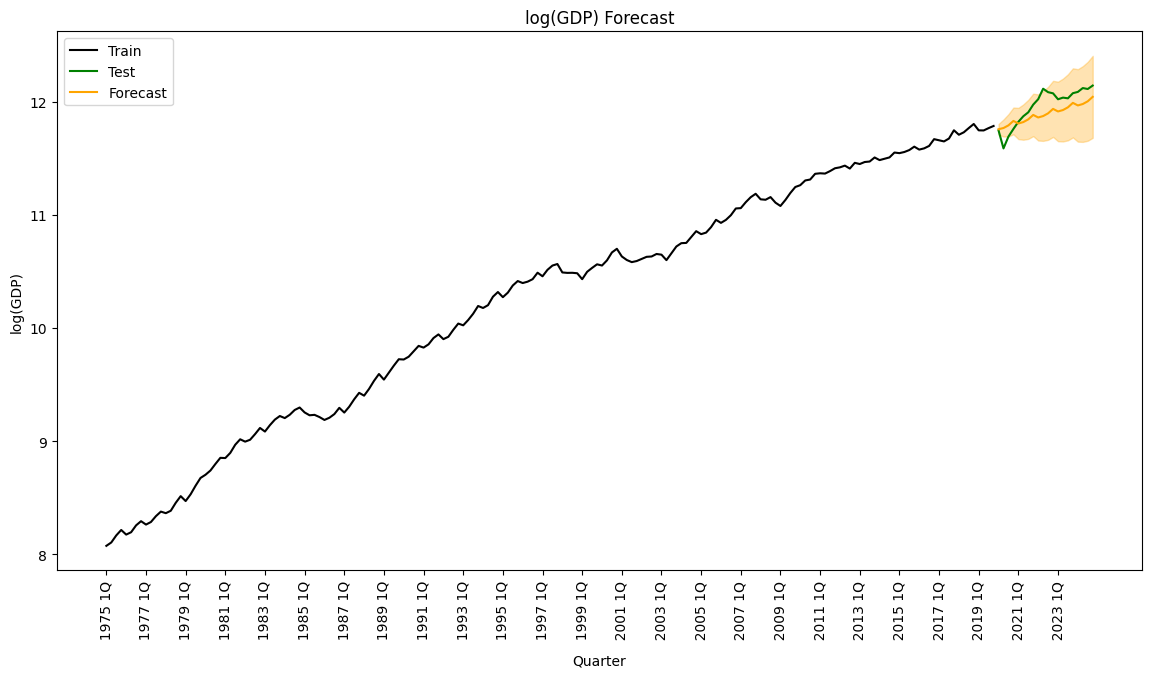

In [29]:
forecast_results = arima_model_fit.get_forecast(steps=len(singapore_gdp_test))
forecast_values = forecast_results.predicted_mean # to get the forecasted values
conf_int = forecast_results.conf_int(alpha = 0.05) # to get 95% confidence intervals for each of the forecasted values

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(singapore_gdp_train["Quarter"], singapore_gdp_train["log(GDP)"], label= "Train", color= "black")
plt.plot(singapore_gdp_test["Quarter"], singapore_gdp_test["log(GDP)"], label= "Test", color= "green")
plt.plot(singapore_gdp_test["Quarter"], forecast_values, label= "Forecast" , color= "orange")

# Confidence band 
# y1 is the column of lower confidence values for the forecast and y2 is the column of upper confidence values for the forecasts
plt.fill_between(singapore_gdp_test["Quarter"], y1 = conf_int.iloc[:, 0], y2 = conf_int.iloc[:, 1], color = "orange", alpha = 0.3)

plt.title("log(GDP) Forecast")

plt.xlabel("Quarter")
plt.xticks(singapore_gdp["Quarter"][::8], rotation = "vertical") # to specify the ticks every 2 years

plt.ylabel("log(GDP)")
plt.legend()
plt.show()


The model generally provides accurate forecasts, effectively capturing the overall upward trend in the data. However, there is a noticeable period where the actual values fall outside the forecast confidence interval. This corresponds to the COVID-19 period, a time of unusual economic disruption that the model, based on historical patterns, could not anticipate.

To improve forecasting performance, we can also consider extend our model to $\text{SARIMAX}$ model (Seasonal $\text{ARIMA}$ with Exogeneous Regressors), where it considers relevant external factors that also affect GDP such as government spending, investments, interest rate etc.

## **2. Error Correction Model**

Having examined the time series behavior and forecasting performance using $\text{SARIMA}$, we now shift our focus toward understanding **long-run equilibrium relationships** between variables. For this, we consider the **Error Correction Model (ECM)** framework, which is particularly useful when variables are **non-stationary in levels but cointegrated** (i.e. they move together over time despite short-term deviations).

In this notebook, we investigate the **long-run and short-run relationship** between **Consumption** and **GDP** using Singapore's economic data. Specifically, we aim to understand how the economy adjusts towards its long-run equilibrium, and how the market self-corrects deviations from **full-employment GDP**.

Section 2.1 and 2.2 are just preliminary analysis of **Consumption**. The procedures and explanations are the same as what was previously applied to **GDP**, including stationarity testing, and differencing where necessary. This ensures that both **Consumption** and **GDP** series are properly prepared for ECM analysis that follows.

### **2.1 Exploratory Data Analysis on Consumption**

In [30]:
df_train = df[:-20].copy()
df_test = df[-20:].copy()

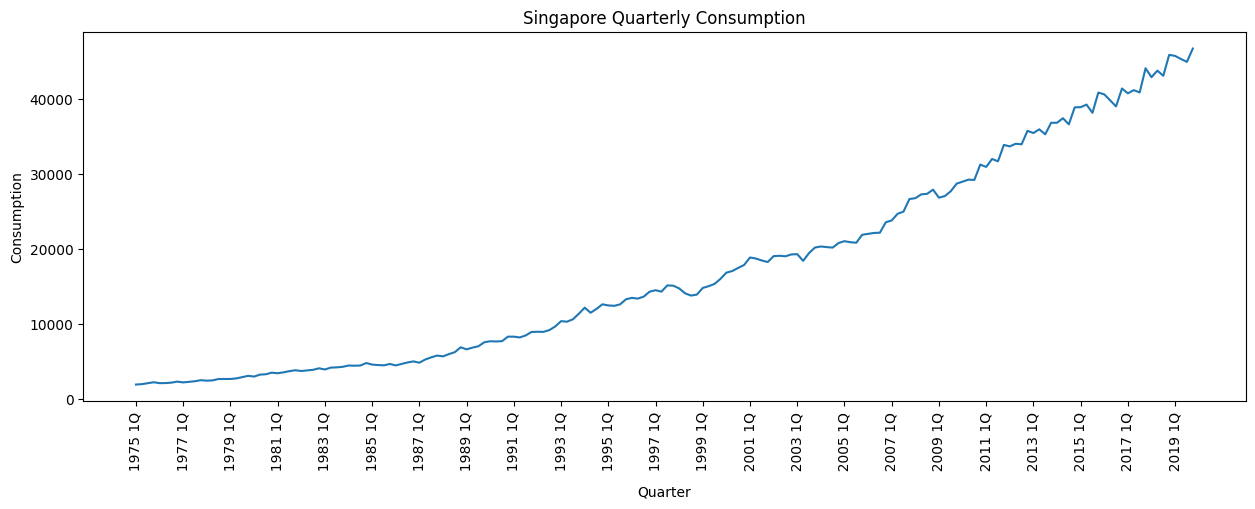

In [31]:
# Plot the GDP against time
plt.figure().set_figwidth(15)
plt.plot(df_train['Quarter'], df_train['Consumption'])
plt.title("Singapore Quarterly Consumption")

plt.xlabel("Quarter")
plt.xticks(df_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("Consumption")
plt.show()

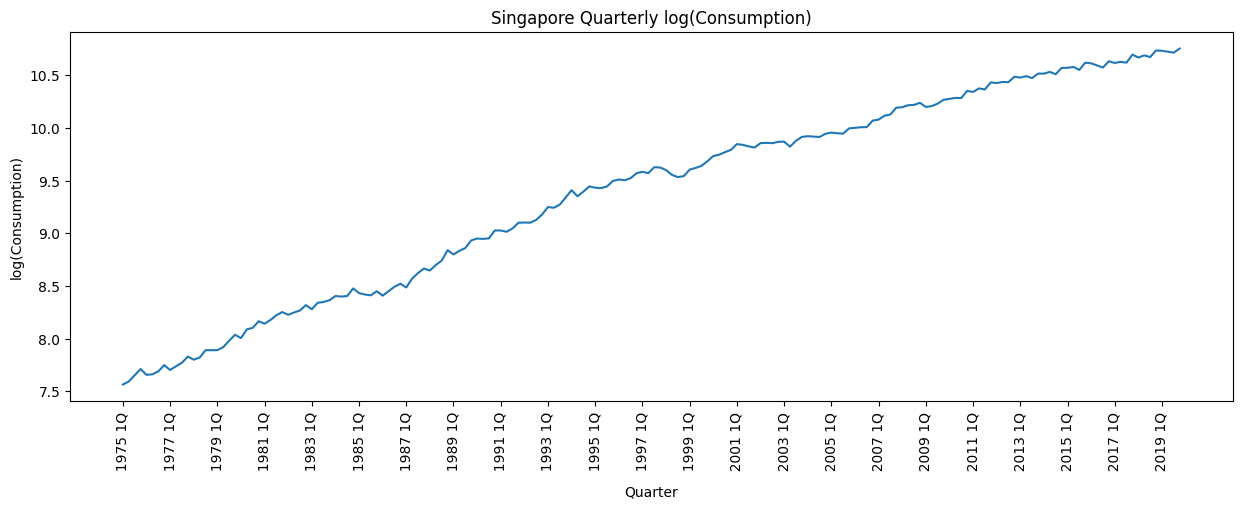

In [32]:
df_train['log(GDP)'] = np.log(df_train['GDP'])
df_train['log(Consumption)'] = np.log(df_train['Consumption'])

# Plotting the log(Consumption) graph against time
plt.figure().set_figwidth(15)
plt.plot(df_train['Quarter'], df_train['log(Consumption)'])
plt.title("Singapore Quarterly log(Consumption)")

plt.xlabel("Quarter")
plt.xticks(df_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("log(Consumption)")
plt.show()

### **2.2 Time Series Analysis on Consumption**

In [33]:
consumption_results = adfuller(df_train['log(Consumption)'])
print("ADF-statistic of log(Consumption): ", consumption_results[0])
print("p-value: ", consumption_results[1])

ADF-statistic of log(Consumption):  -2.5822795647956225
p-value:  0.09671530814718243


In [34]:
df_train['log(Consumption) Lag 1'] = df_train['log(Consumption)'].shift(1)
df_train['log(Consumption) 1st Difference'] = df_train['log(Consumption)'].diff(1)

In [35]:
df_train

,Quarter,GDP,Consumption,log(GDP),log(Consumption),log(Consumption) Lag 1,log(Consumption) 1st Difference
0,1975 1Q,3209.4,1927.0,8.073839,7.563720,NaN,NaN
1,1975 2Q,3307.0,1983.1,8.103797,7.592417,7.563720,0.028697
2,1975 3Q,3519.3,2105.3,8.166017,7.652213,7.592417,0.059797
3,1975 4Q,3693.0,2232.8,8.214194,7.711012,7.652213,0.058798
4,1976 1Q,3545.1,2112.9,8.173322,7.655817,7.711012,-0.055195
...,...,...,...,...,...,...,...
175,2018 4Q,133747.6,45937.7,11.803710,10.735041,10.672250,0.062791
176,2019 1Q,126434.4,45793.9,11.747479,10.731906,10.735041,-0.003135
177,2019 2Q,126324.4,45380.5,11.746608,10.722838,10.731906,-0.009068
178,2019 3Q,128968.5,45000.3,11.767323,10.714424,10.722838,-0.008413


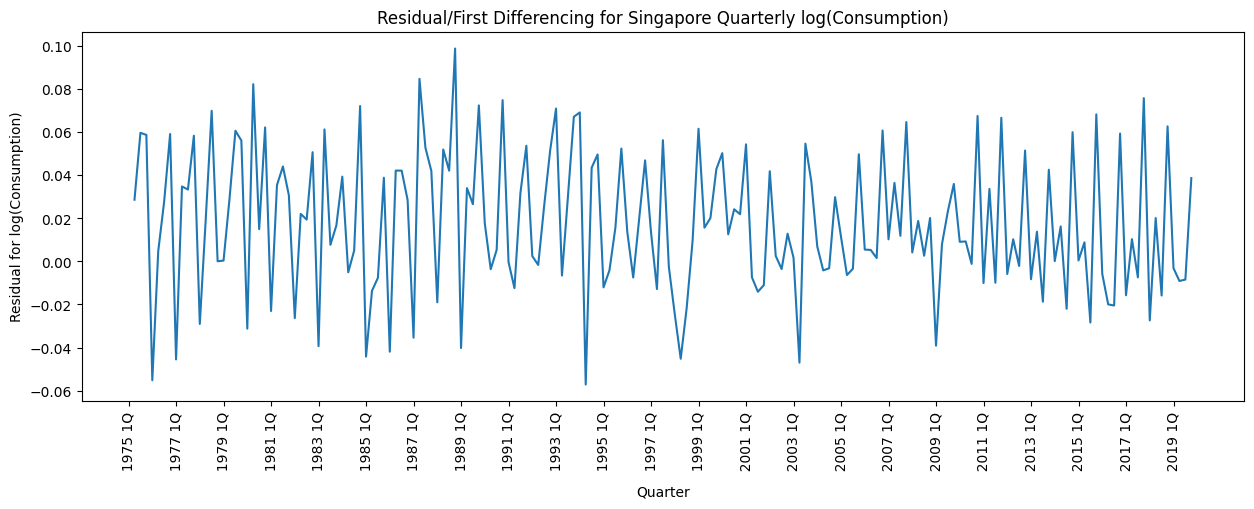

In [36]:
# Plotting the log(GDP) graph against time
plt.figure().set_figwidth(15)
plt.plot(df_train['Quarter'], df_train['log(Consumption) 1st Difference'])
plt.title("Residual/First Differencing for Singapore Quarterly log(Consumption)")

plt.xlabel("Quarter")
plt.xticks(df_train['Quarter'][::8], rotation = 'vertical') # to specify the ticks every 2 years

plt.ylabel("Residual for log(Consumption)")
plt.show()

In [37]:
residual_consumption_results = adfuller(df_train['log(Consumption) 1st Difference'].dropna())
print("ADF-statistic of Residual of log(Consumption): ", residual_consumption_results[0])
print("p-value: ", residual_consumption_results[1])

ADF-statistic of Residual of log(Consumption):  -3.0823848259499194
p-value:  0.027884553605275652


### **2.3 Testing for Cointegration**

In Statistics, there is a famous saying: **Correlation does not imply Causation**. This becomes especially importatn when working with time series data that exhibit trends. **Cointegration** is a statisitcal property describing a **long-term stable relationship** between two or more **non-stationary** time series. It allows us to distinguish **genuine causal relationships** from **misleading correlations** that arise simply due to **shared trend**.

#### **2.3.1 Spurious Regression**

Consider a simple **Finite Distributive Lag** DL(0) model: 

$$y_{t} = \alpha_{0} + \alpha_{1} x_{t} + v_{t}$$

Supposed $y_{t} \sim I(1)$ and $x_{t} \sim I(1)$ and the series $\{y_{t}\}$ and $\{x_{t}\}$ are actually independent of each other.

Since they are no true relationship between the two variables, we expect $\alpha_{1} = 0$. With $\alpha_{1} = 0$, we have $v_{t} = y_{t} - \alpha_{0}$. However, because $\{y_{t}\}$ is a persistent series, the error series $\{v_{t}\}$ will also be persistent, i.e $ v_{t} \sim I(1)$. This **violates** TS 5 No Serial Correlation, **rending standard statistical inference invalid**. 

In particular, if we were to test the following hypothesis:

$$ H_{0} : \alpha_{1} = 0 \quad \text{vs} \quad H_{1} : \alpha_{1} \neq 0$$

More often than not, we will reject $H_{0}$, wrongly concluding the series $\{x_{t}\}$ have significant relationship with $\{y_{t}\}$, even when their relationship is purely random.

**However**, if $\{v_{t}\}$ is actually **stationary**, that is, $v_{t} \sim I(0)$, then we can certain that the **non-stationary (trending)** behaviour of $\{y_{t}\}$ is driven by the **non-stationary** behaviour in $\{x_{t}\}$. In this case, $\{y_{t}\}$ and $\{x_{t}\}$ share a **long-run equilibrium relationship**, and we say that they are **cointegrated**.

#### **2.3.2 Engle Granger Test**

Since $v_{t}$ is **unobservable**, we estimate using $\hat{v}_{t}$:

$$\hat{v}_{t} = y_t - \hat{\alpha}_{0} - \hat{\alpha}_{1} x_t$$

To test whether $\{y_{t}\}$ and $\{x_{t}\}$ are **cointegrated**, we test whether the residual obtained $\hat{v}_{t}$ is of $I(0)$ or $I(1)$. This means we need to test whether $\hat{v}_{t}$ contains a **unit root**.

We use the **Engle-Granger Test** to test whether $\hat{v}_{t}$ contains a **unit root**, by applying **Augmented Dickey-Fuller Test** on $\hat{v}_{t}$. We can say that **Engle-Granger Test** is essentially **Augmented Dickey-Fuller Test** on residual.

Regress the following model:

$$ \hat{v}_{t} = \mu + \rho \hat{v}_{t-1} + e_{t} $$

where $\{e_{t}\}$ is an i.i.d. sequence with $\mathbb{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$.

Following the **Augmented Dickey-Fuller Test** test procedure,

$$ \Delta \hat{v}_{t} = \mu + \theta \hat{v}_{t-1} + e_{t} \quad , \quad \theta = 1- \rho $$

And we test: 

$$ H_{0}: \theta = 0 \quad (u_{t} \sim I(1) \implies \{y_{t}\} \text{ and } \{x_{t}\} \text{ not cointegrated} \implies \text{spurious regression}) $$
$$ H_{1}: \theta \neq 0 \quad (u_{t} \sim I(0)  \implies \{y_{t}\} \text{ and } \{x_{t}\} \text{ cointegrated}) $$

Rejection of $H_{0}$ implies that $\{y_{t}\}$ and $\{x_{t}\}$ are **cointegrated**, i.e. they share a **long-run equilbrium**.

#### Reference:

- Introductory Econometrics: A Modern Approach 5th Edition (by Jeffrey M. Woodridge) Section 18.3 & 18.4

In [38]:
import statsmodels.tsa.stattools as ts 
results = ts.coint(df_train['log(Consumption)'],df_train['log(GDP)'])
print("ADF-statistic (Engle Granger Test): ", results[0])
print("p-value: ", results[1])

ADF-statistic (Engle Granger Test):  -3.407917262190371
p-value:  0.04147868465335957


Since $\text{p-value} < 0.05$, then we can conclude at 5% level of significance that $\{\log(\text{Consumption})\}$ and $\{\log(\text{GDP})\}$ are **cointegrated**.

### **2.4 Derivation and Explanation of Error Correction Model**

Even though we have shown that $\log(\text{GDP})$ exhibits seasonality, we proceed under the assumption that the $\log(\text{GDP}) \sim I(1)$.

Thus, we have established that both $\log(\text{GDP}) \sim I(1)$ and  $\log(\text{Consumption}) \sim I(1)$. Furthermore, they are **cointegrated** based on the results of the **Engle Granger Test**, indicating the presence of **long-run equilibrium relationship** between them.

Assuming we have Auto Regressive Distributed Lag $\text{ADL}(1,0)$ model:

$$\log(\text{GDP}_{t}) = \delta_{0} + \phi_{1} \log(\text{GDP}_{t-1}) + \lambda_{1} \log(\text{Consumption}_{t}) + e_{t}$$

where $\{e_{t}\}$ is an i.i.d. sequence with $\mathbb{E}(e_{t}) = 0, Var(e_{t}) = \sigma^2$

In **long-run equilibrium**, $\log(\text{GDP}_{t}) = \log(\text{GDP}_{t-1}) = \log(\text{GDP}^{*})$, where $\text{GDP}^{*}$ represent **full employment GDP**. Furthermore, there is no error term $e_{t}$ in the **long-run equation** because we expect $e_{t}$ is **zero in expectation** and does not persist. So the **long-run equation** typically does not include an explicit error term. 

The **long-run equation** is written as:

$$ \log(\text{GDP}^{*}) = \delta_{0} + \phi_{1} \log(\text{GDP}^{*}) + \lambda_{1} \log(\text{Consumption}^{*})$$

$$ \implies (1-\phi_{1})\log(\text{GDP}^{*}) = \delta_{0} + \lambda_{1} \log(\text{Consumption}^{*})$$

$$ \implies log(\text{GDP}^{*}) = \dfrac{\delta_{0}}{1- \phi_{1}} + \dfrac{\lambda_{1}}{1- \phi_{1}} \log(\text{Consumption}^{*}) $$

The **Error Correction Model** builds upon the **long-run equilibrium relationship** by incorporating the **short-run dynamics** that describes how the system gradually returns to **equilibrium** after experiencing a shock.

The derivation of our **Error Correction Model**:

$$\log(\text{GDP}_{t}) = \delta_{0} + \phi_{1} \log(\text{GDP}_{t-1}) + \lambda_{1} \log(\text{Consumption}_{t}) + e_{t}$$

We want to apply **differencing** on $\{\log(\text{GDP}_{t})\}$ and $\{\log(\text{Consumption}_{t})\}$ series to transform them into stationary series. To facilitate this, we introduce some additional terms to do so.

Firstly, we subtract both side of the equation by $\log(\text{GDP}_{t-1})$:

$$\Delta \log(\text{GDP}_{t}) = \log(\text{GDP}_{t}) - \log(\text{GDP}_{t-1}) = \delta_{0} + (\phi_{1} - 1) \log(\text{GDP}_{t-1}) + \lambda_{1} \log(\text{Consumption}_{t}) + e_{t}$$

Secondly, we introduce add and subtract $\lambda_{1} \log(\text{Consumption}_{t-1})$ on the RHS of the equation.

$$ \begin{split} 

\implies \Delta \log(\text{GDP}_{t}) = \bigg[\lambda_{1} \log(\text{Consumption}_{t}) - \lambda_{1} \log(\text{Consumption}_{t-1}) \bigg] \\ 

+ \bigg[\delta_{0} - (1-\phi_{1}) \log(\text{GDP}_{t-1}) + \lambda_{1} \log(\text{Consumption}_{t-1}) \bigg] + e_{t}

\end{split} $$

$$ \implies \Delta \log(\text{GDP}_{t}) = \lambda_{1} \Delta \log(\text{Consumption}_{t}) - (1-\phi_{1}) \underbrace{\bigg[\log(\text{GDP}_{t-1}) - \dfrac{\delta_{0}}{(1-\phi_{1})} -  \dfrac{\lambda_{1}}{(1-\phi_{1})} \log(\text{Consumption}_{t-1}) \bigg]}_{\text{disequilibrium }} + e_{t} $$

Finally, we have our **Error Correction Model**:

$$\Delta \log(\text{GDP}_{t}) = \lambda_{1} \Delta \log(\text{Consumption}_{t}) + \gamma s_{t-1} + e_{t} $$

where: 

- $\lambda_{1}$ is the **short-run effect** of $\Delta \log(\text{Consumption})$ on $\Delta \log(\text{GDP})$

- $\gamma = - (1-\phi_{1})$ is the **error correction paramter** or the **speed of adjustment**

- $s_{t-1}$ represents the **disequilibrium of the GDP**

In practice, we expect $-1 < \gamma <0$, with the following error correction mechanism:

- When $\log(\text{GDP})$ overshoots the equilibrium level at time $(t-1)$ (i.e. **inflationary gap**), then $s_{t-1} > 0$. With $\gamma <0$, this gives us $\gamma s_{t-1} < 0$, which **pulls GDP downwards** to equilibrium level at time $t$.

- Similarly, when $\log(\text{GDP})$ undeershoots the equilibrium level at time $(t-1)$ (i.e. **deflationary gap**), then $s_{t-1} < 0$. With $\gamma <0$, this gives us $\gamma s_{t-1} > 0$, and hence **pushing GDP upward** to equilibrium level at time $t$.

- The **Error Correction Model** captures the **dynamic adjustment process**, ensuring that even if short-term shocks cause GDP to deviate from its long run equilibrium path, the model incorporates a mechanism that gradually **adjust GDP back toward equilibrium over time**.

#### Reference: 

- Introductory Econometrics: A Modern Approach 5th Edition (by Jeffrey M. Woodridge) Section 18.4

### **2.5 Engle-Granger Two-Step Procedure**

#### **Step 1: Regress the long-run equation and obtain $\hat{s}_{t-1}$**

Like in many other example, $s_{t-1}$ is usually **unknown**. Therefore, we have to estimate with $\hat{s}_{t-1}$ first.

The **long-run equation** is given by:

$$ log(\text{GDP}_{t}) = \beta_{0} + \beta_{1} \log(\text{Consumption}_{t}) + s_{t} $$

where $\beta_{0} = \dfrac{\delta_{0}}{1- \phi_{1}}$, $\beta_{1} = \dfrac{\lambda_{1}}{1- \phi_{1}}$ as derived earlier in Section 2.4.

Note that we include the $s_{t}$ in the **long-run equation** because, in practice, we **do not observe** the true values of $\beta_{0}$ and $\beta_{1}$. Instead, we **estimate them from the data**.

Regress the **long-run equation** and obtain:

$$ \hat{s}_{t} = log(\text{GDP}_{t}) - \hat{\beta}_{0} - \hat{\beta}_{1} \log(\text{Consumption}_{t}) $$

Lag by one period and we get:

$$ \hat{s}_{t-1} = log(\text{GDP}_{t-1}) - \hat{\beta}_{0} - \hat{\beta}_{1} \log(\text{Consumption}_{t-1}) $$

#### **Step 2: Estimate the Error Correction Model**

Using $\hat{s}_{t-1}$ in place of $s_{t-1}$, we regress the **Error Correction Model**:

$$\Delta \log(\text{GDP}_{t}) = \lambda_{1} \Delta \log(\text{Consumption}_{t}) + \gamma \hat{s}_{t-1} + e_{t} $$

and obtain the OLS parameters $\hat{\lambda}_{1}$ and $\hat{\gamma}$

#### Reference:

- Introductory Econometrics: A Modern Approach 5th Edition (by Jeffrey M. Woodridge) Section 18.4

In [39]:
import statsmodels.api as sm

x_train = sm.add_constant(df_train['log(Consumption)'])

y_train = df_train['log(GDP)']

lr_model_train = sm.OLS(y_train,x_train, missing = 'drop').fit()

df_train['residual'] = lr_model_train.resid

print(lr_model_train.summary())

                            OLS Regression Results                            
Dep. Variable:               log(GDP)   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 5.206e+04
Date:                Fri, 18 Apr 2025   Prob (F-statistic):          1.47e-221
Time:                        16:13:19   Log-Likelihood:                 243.14
No. Observations:                 180   AIC:                            -482.3
Df Residuals:                     178   BIC:                            -475.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3941      0.047  

**Comments on the long-run equation model results:**

- The $R^2$ value from the regression is extremely high. In many other contexts, this could be a concern as it may indicate overfitting or spurious correlation, especially when working with non-stationary data.

- However, in this case, from a practical economic standpoint, **Consumption** and **GDP** are intrinsically linked — they move closely together over time. Therefore, a high $R^2$ is expected and reasonable. We will proceed to use the residuals from this regression as our **error correction term** in the next step.

In [40]:
df_train['residual Lag 1'] = df_train['residual'].shift(1)

In [41]:
df_train['log(GDP) Lag 1'] = df_train['log(GDP)'].shift(1)
df_train['log(GDP) 1st Difference'] = df_train['log(GDP)'].diff(1)
 
X_train = df_train[['log(Consumption) 1st Difference', 'residual Lag 1']]

Y_train = df_train['log(GDP) 1st Difference']

ECM_model = sm.OLS(Y_train,X_train, missing = 'drop').fit()

print(ECM_model.summary())

                                   OLS Regression Results                                   
Dep. Variable:     log(GDP) 1st Difference   R-squared (uncentered):                   0.459
Model:                                 OLS   Adj. R-squared (uncentered):              0.452
Method:                      Least Squares   F-statistic:                              74.95
Date:                     Fri, 18 Apr 2025   Prob (F-statistic):                    2.63e-24
Time:                             16:13:19   Log-Likelihood:                          372.91
No. Observations:                      179   AIC:                                     -741.8
Df Residuals:                          177   BIC:                                     -735.4
Df Model:                                2                                                  
Covariance Type:                 nonrobust                                                  
                                      coef    std err          t      

**Comments on the estimation of Error Correction Model results**

- Coefficient of residual Lag 1 ($\gamma$) is the speed of adjustment, which is negative, just as we expected. This confirms the self-adjusting mechanism, where deviations from the **long-run equilibrium** are corrected over time.

- **Durbin-Watson Test Statistic** ranges from 0 to 4. 

    - Value **significantly less than 2** suggests **positive autocorrelation** in the residual

    - Value **significantly greater than 2** suggests **negative autocorrelation** in the residual 

    - Value **around 2** suggests **no autocorrelation** in the residuals.

    - Since DW statistic of 1.938 is extremely close to 2, it suggests that the residuals are **almost uncorrelated** and can be treated as **white noise**, which is ideal for any time series model.

- When $\log(\text{GDP})$ **overshoots** from its equilibrium at level time $(t-1)$: 

    - 1. **Change in GDP** is too quick relative to the **Change in Consumption**
    - 2. Inventory builds up
    - 3. Firms cut down production
    - 4. GDP falls, pulling it downwards and return back to the long-run equilibrium path

- When $\log(\text{GDP})$ **undershoots** from its equilibrium at level time $(t-1)$: 

    - 1. **Change in GDP** is too slow relative to the **Change in Consumption**
    - 2. Demand outpaces Supply
    - 3. Firms produces more goods to meet the demand
    - 4. GDP rises, pushing it upwards and return back to the long-run equilibrium path

### **2.6 Out-of-Sample Forecasting for Error Correction Model**

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Quarter                          180 non-null    object 
 1   GDP                              180 non-null    float64
 2   Consumption                      180 non-null    float64
 3   log(GDP)                         180 non-null    float64
 4   log(Consumption)                 180 non-null    float64
 5   log(Consumption) Lag 1           179 non-null    float64
 6   log(Consumption) 1st Difference  179 non-null    float64
 7   residual                         180 non-null    float64
 8   residual Lag 1                   179 non-null    float64
 9   log(GDP) Lag 1                   179 non-null    float64
 10  log(GDP) 1st Difference          179 non-null    float64
dtypes: float64(10), object(1)
memory usage: 15.6+ KB


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 180 to 199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Quarter      20 non-null     object 
 1   GDP          20 non-null     float64
 2   Consumption  20 non-null     float64
dtypes: float64(2), object(1)
memory usage: 612.0+ bytes


In [44]:
df_test['log(GDP)'] = np.log(df_test['GDP'])
df_test['log(GDP) Lag 1'] = df_test['log(GDP)'].shift(1)
df_test['log(GDP) 1st Difference'] = df_test['log(GDP)'].diff(1)

df_test['log(Consumption)'] = np.log(df_test['Consumption'])
df_test['log(Consumption) Lag 1'] = df_test['log(Consumption)'].shift(1)
df_test['log(Consumption) 1st Difference'] = df_test['log(Consumption)'].diff(1)

In [45]:
x_test = sm.add_constant(df_test['log(Consumption)'])

y_test = df_test['log(GDP)']

lr_model_test = sm.OLS(y_test,x_test, missing = 'drop').fit()

df_test['residual'] = lr_model_test.resid

print(lr_model_test.summary())

                            OLS Regression Results                            
Dep. Variable:               log(GDP)   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     92.70
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.59e-08
Time:                        16:13:19   Log-Likelihood:                 26.488
No. Observations:                  20   AIC:                            -48.98
Df Residuals:                      18   BIC:                            -46.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2684      1.007  

In [46]:
df_test['residual Lag 1'] = df_test['residual'].shift(1)

In [47]:
pred_change_in_log_GDP = ECM_model.predict(df_test[['log(Consumption) 1st Difference', 'residual Lag 1']])

Mean Absolute Percentage Error (MAPE) is commonly used to test the accuracy of any time series forecasting model, and is given by this formula:

$$ \text{MAPE} = \dfrac{1}{n} \sum_{t = 1}^{T} \bigg|\dfrac{A_{t} - F_{t}}{A_{t}} \bigg| \times 100 \% $$

The lower the MAPE, the more accurate the model is. Generally, a model with less than 10% is a highly accurate prediction.

In [48]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(pred_change_in_log_GDP[1:], df_test['log(GDP) 1st Difference'][1:])

print(f"The Mean Absolute Percentage Error of the prediction is ", MAPE, "%")


The Mean Absolute Percentage Error of the prediction is  6.92889173667012 %


**Additional Comments on Error Correction Model**:

The model achieves a Mean Absolute Percentage Error (MAPE) of approximately 7%, indicating a high level of forecasting accuracy. However, it is important to note that there are other factors that influence GDP.

## **Conclusion**

##### This notebook explored the mathematical foundations of time series analysis through Singapore's GDP and Consumption data case study. While the focus was on macroeconomic indicators, the concepts and techniques demonstrated such as **Unit Root Test, Differencing, ACF and PACF, SARIMA** are widely applicable across various domains beyond Economics, including **weather forecasting** in Environmental Science, **signal processing** in Electrical Engineering and many more.

##### Hopefully, this notebook serves as a practical and insightful resource for anyone interested in learning how time series models can be used to uncover patterns, make forecasts, and understand dynamic relationships in real-world data.